Loaded 1096 rows, date range 2020-01-01 to 2022-12-31
Train size: 852, Test size: 214
Naive -> RMSE: 19.17, MAPE: 7.79%
SARIMA -> RMSE: 26.21, MAPE: 10.34%
xgboost -> RMSE: 15.89, MAPE: 6.75%
Ensemble weights: {'naive': 0.34035277949415854, 'sarima': 0.24894661347154973, 'xgboost': 0.41070060703429173}
Ensemble -> RMSE: 15.67, MAPE: 6.52%
Forecast results written to forecast_results.csv


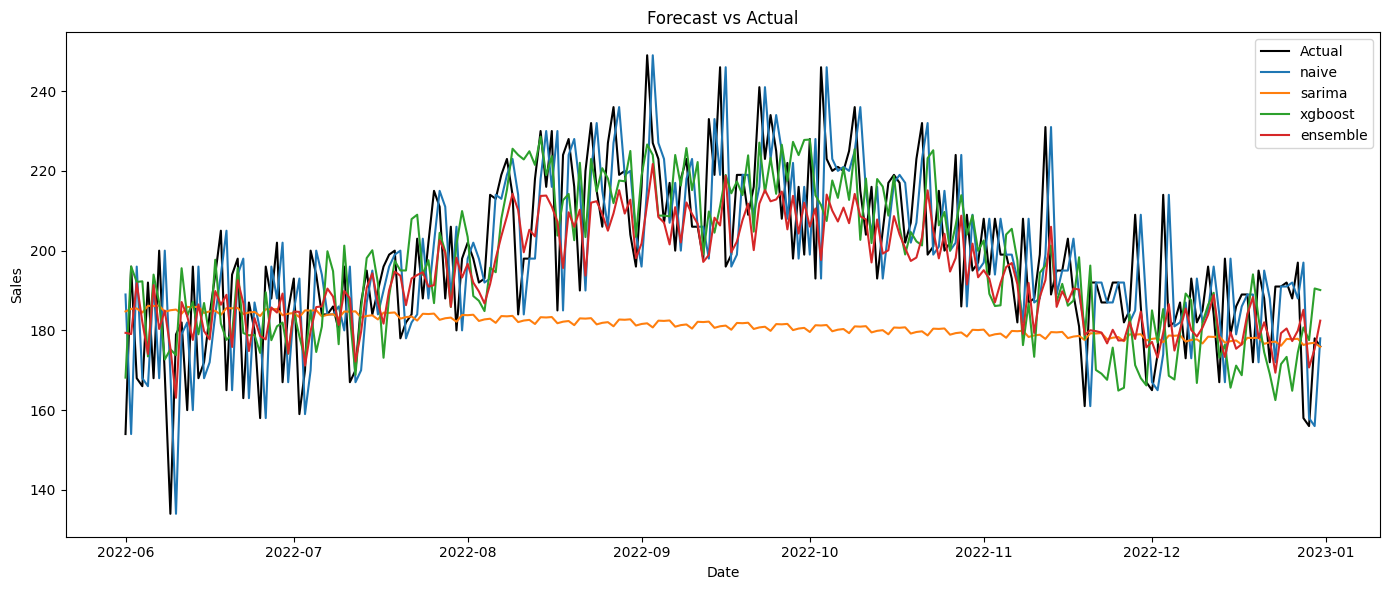

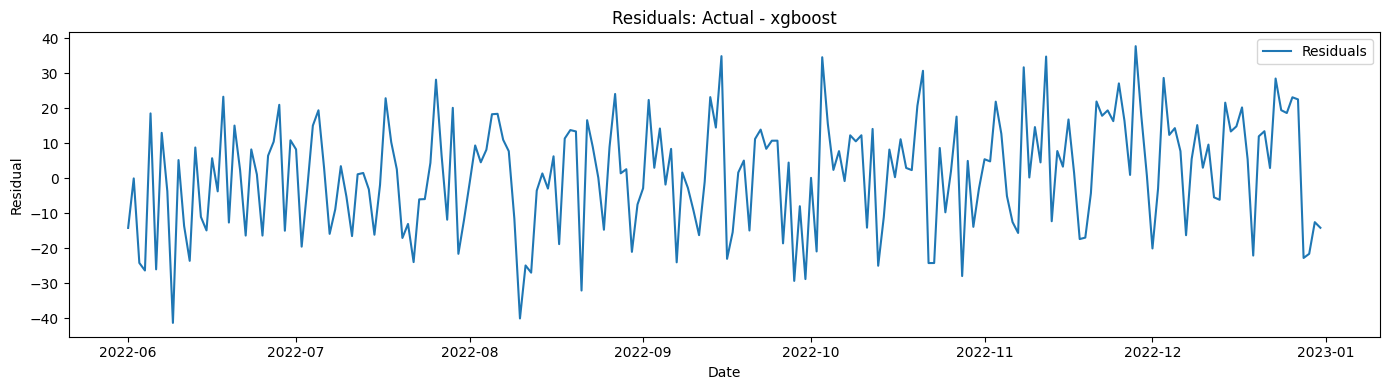

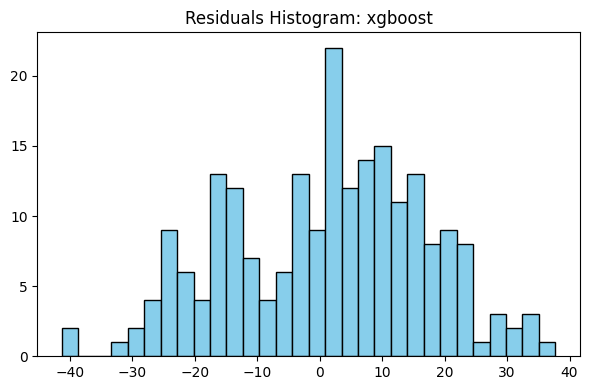

Top features:
 rolling_mean_7    0.493904
month             0.125068
dayofweek         0.109142
lag_30            0.099010
lag_7             0.096539
lag_1             0.076337
dtype: float32


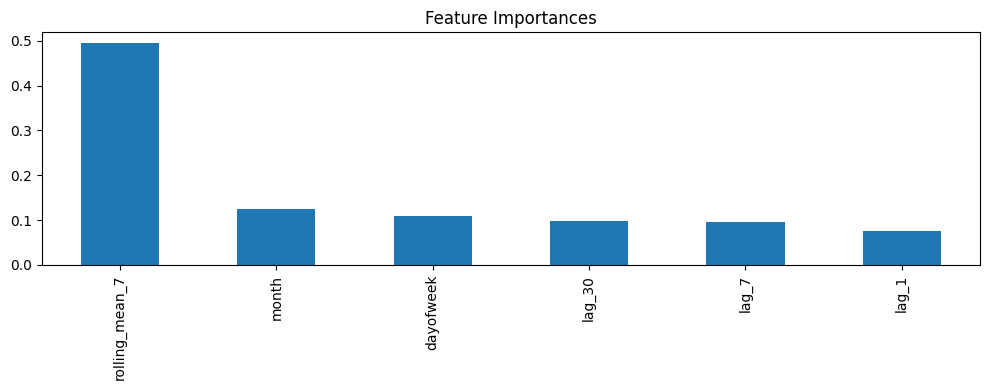

In [54]:
#!/usr/bin/env python3
"""
forecasting_demo_full.py

- Loads sample_data.csv with 'date' and 'sales'
- Creates lag/rolling features
- Naive baseline, SARIMA (optional), XGBoost (or RandomForest fallback)
- Computes weighted ensemble
- Evaluates RMSE / MAPE
- Plots actual vs forecasts, residuals, and XGBoost feature importance
- Saves CSVs for results, residuals, and feature importances
"""

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

DATA_FILE = "sample_data.csv"
OUT_FILE = "forecast_results.csv"

# ------------------------
# Data prep and features
# ------------------------

def load_data(path=DATA_FILE):
    df = pd.read_csv(path, parse_dates=["date"])
    df = df.sort_values("date").set_index("date")
    return df

def create_features(df, lags=(1,7,30)):
    data = df.copy()
    for lag in lags:
        data[f"lag_{lag}"] = data["sales"].shift(lag)
    data["rolling_mean_7"] = data["sales"].shift(1).rolling(7).mean()
    data["dayofweek"] = data.index.dayofweek
    data["month"] = data.index.month
    data = data.dropna()
    return data

def train_test_split(data, train_frac=0.8):
    n = int(len(data) * train_frac)
    train = data.iloc[:n].copy()
    test = data.iloc[n:].copy()
    return train, test

# ------------------------
# Metrics
# ------------------------

def evaluate(y_true, y_pred):
    y_true, y_pred = y_true.align(y_pred, join="inner")
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mask = (y_true != 0)
    if mask.sum() == 0:
        mape = float("nan")
    else:
        mape = float(np.mean(np.abs((y_true[mask]-y_pred[mask])/y_true[mask]))*100)
    return rmse, mape

# ------------------------
# Forecasting models
# ------------------------

def baseline_naive(test):
    return test["lag_1"]

def try_sarima(train, test):
    try:
        from statsmodels.tsa.statespace.sarimax import SARIMAX
    except Exception as e:
        print("statsmodels not available:", e)
        return None
    try:
        model = SARIMAX(train["sales"], order=(1,1,1),
                        seasonal_order=(1,1,1,7),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        res = model.fit(disp=False)
        pred = res.get_prediction(start=test.index[0], end=test.index[-1]).predicted_mean
        pred = pred.reindex(test.index)
        return pred
    except Exception as e:
        print("SARIMA training/prediction failed:", e)
        return None

def try_xgboost_or_rf(train, test, features, random_state=42):
    X_train = train[features].copy()
    y_train = train["sales"].copy()
    X_test = test[features].copy()
    # Drop rows with NaNs
    train_mask = X_train.notna().all(axis=1)
    test_mask = X_test.notna().all(axis=1)
    X_train, y_train = X_train[train_mask], y_train[train_mask]
    X_test = X_test[test_mask]
    if len(X_train)==0 or len(X_test)==0:
        print("Not enough data after dropping NaNs")
        return None, None, None
    try:
        import xgboost as xgb
        model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, random_state=random_state)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return pd.Series(preds, index=X_test.index), model, "xgboost"
    except Exception as e_xgb:
        from sklearn.ensemble import RandomForestRegressor
        print("xgboost not available, falling back to RandomForest:", e_xgb)
        rf = RandomForestRegressor(n_estimators=200, random_state=random_state)
        rf.fit(X_train, y_train)
        preds = rf.predict(X_test)
        return pd.Series(preds, index=X_test.index), rf, "random_forest"

# ------------------------
# Plotting
# ------------------------

def plot_forecasts(results, title="Forecast vs Actual"):
    plt.figure(figsize=(14,6))
    plt.plot(results.index, results["sales"], label="Actual", color="black")
    for col in results.columns:
        if col != "sales":
            plt.plot(results.index, results[col], label=col)
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_residuals(results, model_col):
    residuals = results["sales"] - results[model_col]
    plt.figure(figsize=(14,4))
    plt.plot(residuals.index, residuals, label="Residuals")
    plt.xlabel("Date")
    plt.ylabel("Residual")
    plt.title(f"Residuals: Actual - {model_col}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=30, color="skyblue", edgecolor="black")
    plt.title(f"Residuals Histogram: {model_col}")
    plt.tight_layout()
    plt.show()
    return residuals

def plot_feature_importance(model, features):
    try:
        importances = model.feature_importances_
        feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
        print("Top features:\n", feat_imp.head(10))
        feat_imp.to_csv("feature_importances.csv")
        feat_imp.plot(kind="bar", figsize=(10,4), title="Feature Importances")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Could not plot feature importances:", e)

# ------------------------
# Main
# ------------------------

def main():
    df = load_data()
    print(f"Loaded {len(df)} rows, date range {df.index.min().date()} to {df.index.max().date()}")
    data = create_features(df)
    train, test = train_test_split(data)
    print(f"Train size: {len(train)}, Test size: {len(test)}")
    results = test[["sales"]].copy()

    # Naive
    results["naive"] = baseline_naive(test)
    rmse, mape = evaluate(results["sales"], results["naive"])
    print(f"Naive -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # SARIMA
    sarima_pred = try_sarima(train, test)
    if sarima_pred is not None:
        results["sarima"] = sarima_pred
        rmse, mape = evaluate(results["sales"], results["sarima"])
        print(f"SARIMA -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    else:
        print("SARIMA skipped")

    # XGBoost / RandomForest
    features = [c for c in data.columns if c != "sales"]
    x_pred, model, model_name = try_xgboost_or_rf(train, test, features)
    if x_pred is not None:
        results[model_name] = x_pred
        rmse, mape = evaluate(results["sales"], results[model_name])
        print(f"{model_name} -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    else:
        print("No tree-based model predictions produced")

    # Ensemble: inverse RMSE weighting
    model_rmse = {}
    for col in ["naive", "sarima", model_name]:
        if col in results.columns:
            try:
                rmse_val, _ = evaluate(results["sales"], results[col])
                model_rmse[col] = rmse_val
            except:
                pass
    if model_rmse:
        inv = {k:1/v for k,v in model_rmse.items()}
        s = sum(inv.values())
        weights = {k: inv[k]/s for k in inv}
        print("Ensemble weights:", weights)
        mask_any = results[[c for c in weights.keys()]].notna().any(axis=1)
        ensemble_series = pd.Series(np.nan, index=results.index)
        ensemble_series.loc[mask_any] = sum((results[col].loc[mask_any]*weights[col] for col in weights.keys()))
        results["ensemble"] = ensemble_series
        mask_eval = results["ensemble"].notna()
        if mask_eval.any():
            rmse, mape = evaluate(results.loc[mask_eval,"sales"], results.loc[mask_eval,"ensemble"])
            print(f"Ensemble -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # Save results
    results.to_csv(OUT_FILE)
    print(f"Forecast results written to {OUT_FILE}")

    # Plots
    plot_forecasts(results)
    if model_name in results.columns:
        residuals = plot_residuals(results, model_name)
        residuals.to_csv(f"residuals_{model_name}.csv")
        if model_name=="xgboost":
            plot_feature_importance(model, features)

if __name__=="__main__":
    main()


Loaded 1096 rows, date range 2020-01-01 to 2022-12-31
Train size: 804, Test size: 202
Naive -> RMSE: 18.34, MAPE: 7.31%
SARIMA -> RMSE: 35.87, MAPE: 15.01%
xgboost -> RMSE: 3.85, MAPE: 1.48%
Ensemble weights: {'naive': 0.15941922642351117, 'sarima': 0.0814928295872952, 'xgboost': 0.7590879439891937}
Ensemble -> RMSE: 5.40, MAPE: 2.03%
Forecast results written to forecast_results.csv


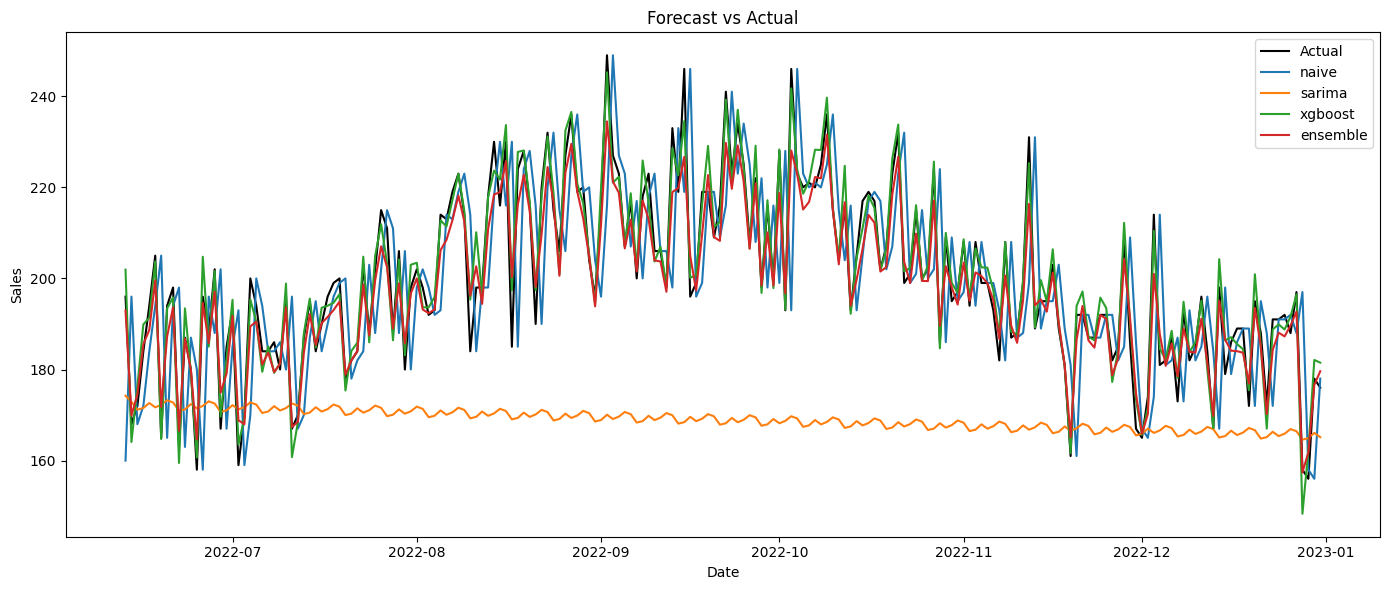

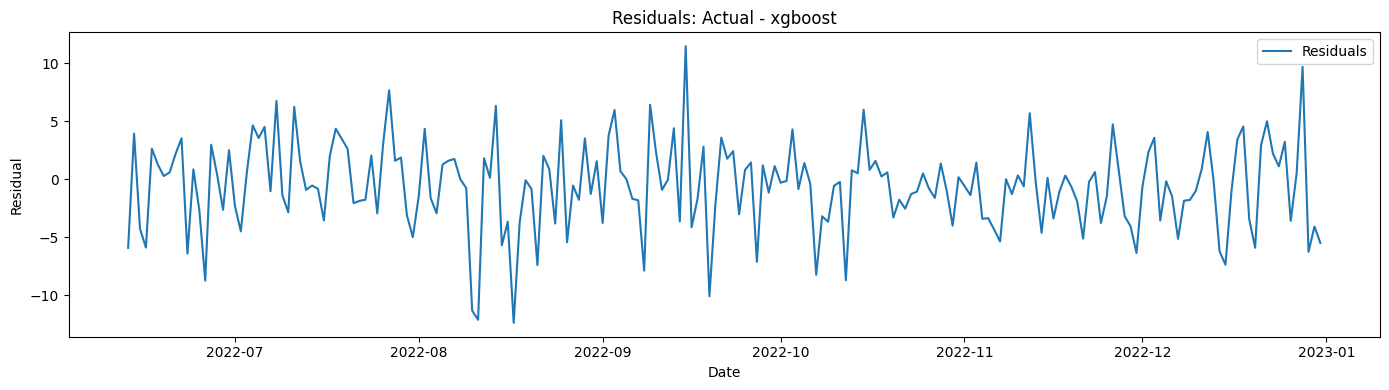

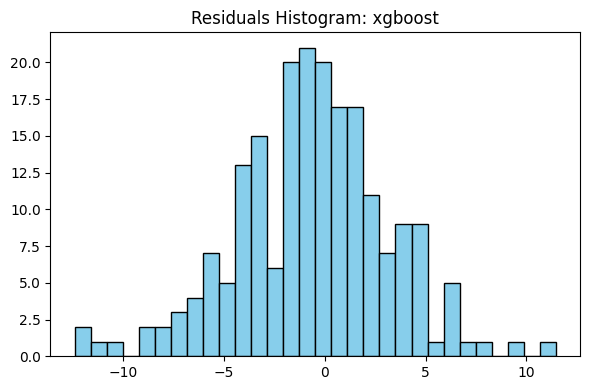

Top features:
 rolling_mean_14    0.287021
ewm_mean_7         0.167705
pct_change_1       0.104523
residual_naive     0.085096
rolling_mean_7     0.083748
pct_change_30      0.060910
pct_change_7       0.044254
pct_change_14      0.040883
lag1_x_rm7         0.035219
lag7_x_rm7         0.022971
dtype: float32


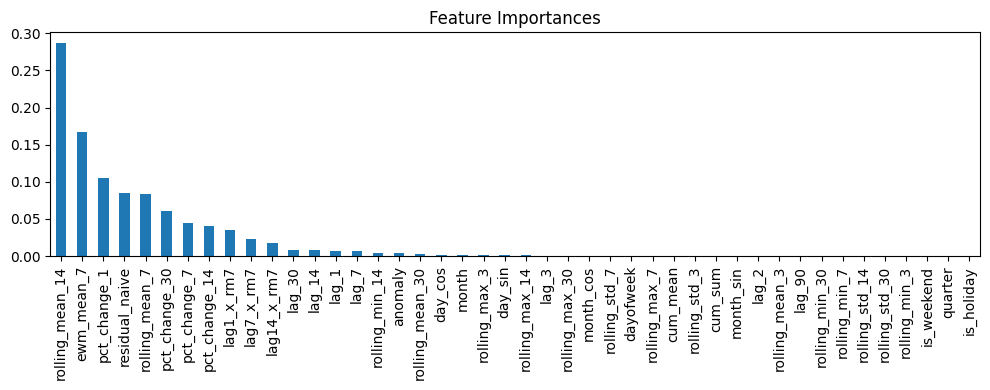

In [56]:
#!/usr/bin/env python3
"""
forecasting_demo_full_features.py

- Loads sample_data.csv with 'date' and 'sales'
- Creates extended lag/rolling/cyclical/calendar/external features
- Naive baseline, SARIMA (optional), XGBoost (or RandomForest fallback)
- Computes weighted ensemble
- Evaluates RMSE / MAPE
- Generates plots
- Saves forecast_results.csv, residuals, feature_importances
"""

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# For holidays
try:
    import holidays
    us_holidays = holidays.US()
except ImportError:
    us_holidays = None

DATA_FILE = "sample_data.csv"
OUT_FILE = "forecast_results.csv"

# ------------------------
# Data prep and feature engineering
# ------------------------

def load_data(path=DATA_FILE):
    df = pd.read_csv(path, parse_dates=["date"])
    df = df.sort_values("date").set_index("date")
    return df

def create_features(df):
    data = df.copy()
    # --- Lags ---
    lags = [1,2,3,7,14,30,90]
    for lag in lags:
        data[f"lag_{lag}"] = data["sales"].shift(lag)

    # --- Rolling stats ---
    windows = [3,7,14,30]
    for w in windows:
        data[f"rolling_mean_{w}"] = data["sales"].shift(1).rolling(w).mean()
        data[f"rolling_std_{w}"] = data["sales"].shift(1).rolling(w).std()
        data[f"rolling_min_{w}"] = data["sales"].shift(1).rolling(w).min()
        data[f"rolling_max_{w}"] = data["sales"].shift(1).rolling(w).max()

    # --- Exponentially weighted mean ---
    data["ewm_mean_7"] = data["sales"].shift(1).ewm(span=7).mean()

    # --- Percentage changes ---
    for lag in [1,7,14,30]:
        data[f"pct_change_{lag}"] = data["sales"].pct_change(lag)

    # --- Cumulative features ---
    data["cum_sum"] = data["sales"].cumsum()
    data["cum_mean"] = data["sales"].expanding().mean()

    # --- Calendar features ---
    data["dayofweek"] = data.index.dayofweek
    data["month"] = data.index.month
    data["quarter"] = data.index.quarter
    data["is_weekend"] = data["dayofweek"] >= 5

    # --- Cyclical encoding ---
    data["day_sin"] = np.sin(2*np.pi*data.index.day/31)
    data["day_cos"] = np.cos(2*np.pi*data.index.day/31)
    data["month_sin"] = np.sin(2*np.pi*data.index.month/12)
    data["month_cos"] = np.cos(2*np.pi*data.index.month/12)

    # --- Holiday flag ---
    if us_holidays:
        data["is_holiday"] = data.index.isin(us_holidays)
    else:
        data["is_holiday"] = 0

    # --- Interaction features ---
    for lag in [1,7,14]:
        if f"lag_{lag}" in data.columns:
            data[f"lag{lag}_x_rm7"] = data[f"lag_{lag}"] * data["rolling_mean_7"]

    # --- Naive residual / anomaly ---
    data["residual_naive"] = data["sales"] - data["lag_1"]
    data["anomaly"] = (data["residual_naive"].abs() > 3*data["rolling_std_7"])

    data = data.dropna()
    return data

def train_test_split(data, train_frac=0.8):
    n = int(len(data) * train_frac)
    train = data.iloc[:n].copy()
    test = data.iloc[n:].copy()
    return train, test

# ------------------------
# Metrics
# ------------------------

def evaluate(y_true, y_pred):
    y_true, y_pred = y_true.align(y_pred, join="inner")
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mask = (y_true != 0)
    if mask.sum() == 0:
        mape = float("nan")
    else:
        mape = float(np.mean(np.abs((y_true[mask]-y_pred[mask])/y_true[mask]))*100)
    return rmse, mape

# ------------------------
# Forecasting models
# ------------------------

def baseline_naive(test):
    return test["lag_1"]

def try_sarima(train, test):
    try:
        from statsmodels.tsa.statespace.sarimax import SARIMAX
    except Exception as e:
        print("statsmodels not available:", e)
        return None
    try:
        model = SARIMAX(train["sales"], order=(1,1,1),
                        seasonal_order=(1,1,1,7),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        res = model.fit(disp=False)
        pred = res.get_prediction(start=test.index[0], end=test.index[-1]).predicted_mean
        pred = pred.reindex(test.index)
        return pred
    except Exception as e:
        print("SARIMA training/prediction failed:", e)
        return None

def try_xgboost_or_rf(train, test, features, random_state=42):
    X_train = train[features].copy()
    y_train = train["sales"].copy()
    X_test = test[features].copy()
    # Drop rows with NaNs
    train_mask = X_train.notna().all(axis=1)
    test_mask = X_test.notna().all(axis=1)
    X_train, y_train = X_train[train_mask], y_train[train_mask]
    X_test = X_test[test_mask]
    if len(X_train)==0 or len(X_test)==0:
        print("Not enough data after dropping NaNs")
        return None, None, None
    try:
        import xgboost as xgb
        model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, random_state=random_state)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return pd.Series(preds, index=X_test.index), model, "xgboost"
    except Exception as e_xgb:
        from sklearn.ensemble import RandomForestRegressor
        print("xgboost not available, falling back to RandomForest:", e_xgb)
        rf = RandomForestRegressor(n_estimators=200, random_state=random_state)
        rf.fit(X_train, y_train)
        preds = rf.predict(X_test)
        return pd.Series(preds, index=X_test.index), rf, "random_forest"

# ------------------------
# Plotting
# ------------------------

def plot_forecasts(results, title="Forecast vs Actual"):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(14,6))
    plt.plot(results.index, results["sales"], label="Actual", color="black")
    for col in results.columns:
        if col != "sales":
            plt.plot(results.index, results[col], label=col)
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_residuals(results, model_col):
    residuals = results["sales"] - results[model_col]
    plt.figure(figsize=(14,4))
    plt.plot(residuals.index, residuals, label="Residuals")
    plt.xlabel("Date")
    plt.ylabel("Residual")
    plt.title(f"Residuals: Actual - {model_col}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=30, color="skyblue", edgecolor="black")
    plt.title(f"Residuals Histogram: {model_col}")
    plt.tight_layout()
    plt.show()
    return residuals

def plot_feature_importance(model, features):
    try:
        importances = model.feature_importances_
        feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
        print("Top features:\n", feat_imp.head(10))
        feat_imp.to_csv("feature_importances.csv")
        feat_imp.plot(kind="bar", figsize=(10,4), title="Feature Importances")
        import matplotlib.pyplot as plt
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Could not plot feature importances:", e)

# ------------------------
# Main
# ------------------------

def main():
    df = load_data()
    print(f"Loaded {len(df)} rows, date range {df.index.min().date()} to {df.index.max().date()}")
    data = create_features(df)
    train, test = train_test_split(data)
    print(f"Train size: {len(train)}, Test size: {len(test)}")
    results = test[["sales"]].copy()

    # Naive
    results["naive"] = baseline_naive(test)
    rmse, mape = evaluate(results["sales"], results["naive"])
    print(f"Naive -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # SARIMA
    sarima_pred = try_sarima(train, test)
    if sarima_pred is not None:
        results["sarima"] = sarima_pred
        rmse, mape = evaluate(results["sales"], results["sarima"])
        print(f"SARIMA -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    else:
        print("SARIMA skipped")

    # XGBoost / RandomForest
    features = [c for c in data.columns if c != "sales"]
    x_pred, model, model_name = try_xgboost_or_rf(train, test, features)
    if x_pred is not None:
        results[model_name] = x_pred
        rmse, mape = evaluate(results["sales"], results[model_name])
        print(f"{model_name} -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    else:
        print("No tree-based model predictions produced")

    # Ensemble: inverse RMSE weighting
    model_rmse = {}
    for col in ["naive","sarima",model_name]:
        if col in results.columns:
            try:
                rmse_val, _ = evaluate(results["sales"], results[col])
                model_rmse[col] = rmse_val
            except:
                pass
    if model_rmse:
        inv = {k:1/v for k,v in model_rmse.items()}
        s = sum(inv.values())
        weights = {k: inv[k]/s for k in inv}
        print("Ensemble weights:", weights)
        mask_any = results[[c for c in weights.keys()]].notna().any(axis=1)
        ensemble_series = pd.Series(np.nan, index=results.index)
        ensemble_series.loc[mask_any] = sum((results[col].loc[mask_any]*weights[col] for col in weights.keys()))
        results["ensemble"] = ensemble_series
        mask_eval = results["ensemble"].notna()
        if mask_eval.any():
            rmse, mape = evaluate(results.loc[mask_eval,"sales"], results.loc[mask_eval,"ensemble"])
            print(f"Ensemble -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # Save results
    results.to_csv(OUT_FILE)
    print(f"Forecast results written to {OUT_FILE}")

    # Plots
    plot_forecasts(results)
    if model_name in results.columns:
        residuals = plot_residuals(results, model_name)
        residuals.to_csv(f"residuals_{model_name}.csv")
        if model_name=="xgboost":
            plot_feature_importance(model, features)

if __name__=="__main__":
    main()



Naive -> RMSE: 19.17, MAPE: 7.79%
SARIMA -> RMSE: 26.21, MAPE: 10.34%
xgboost -> RMSE: 3.29, MAPE: 1.31%
Ensemble -> RMSE: 4.95, MAPE: 1.93%
Forecast results saved to forecast_results.csv


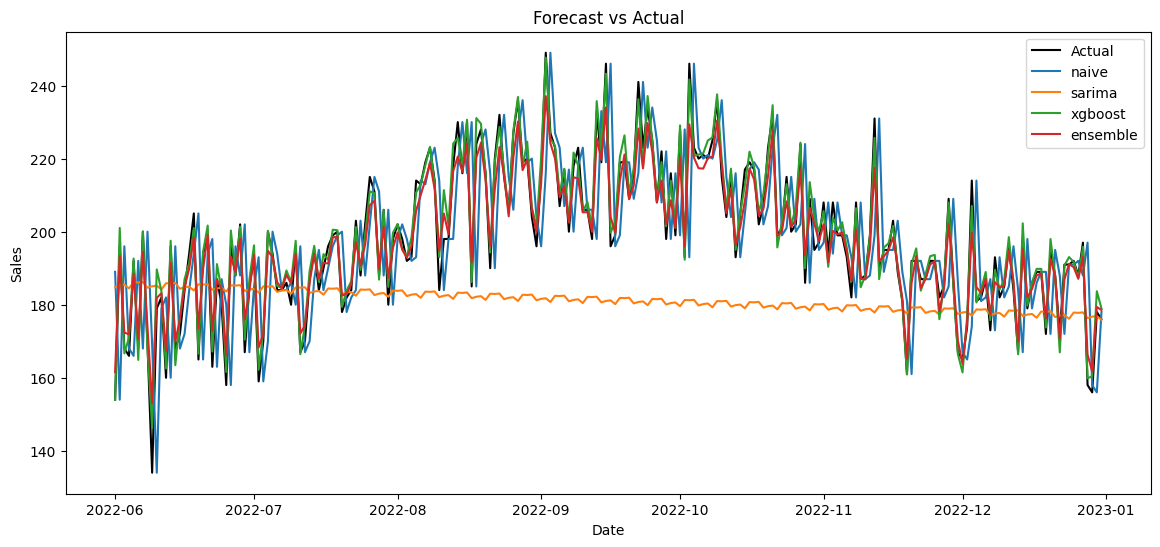

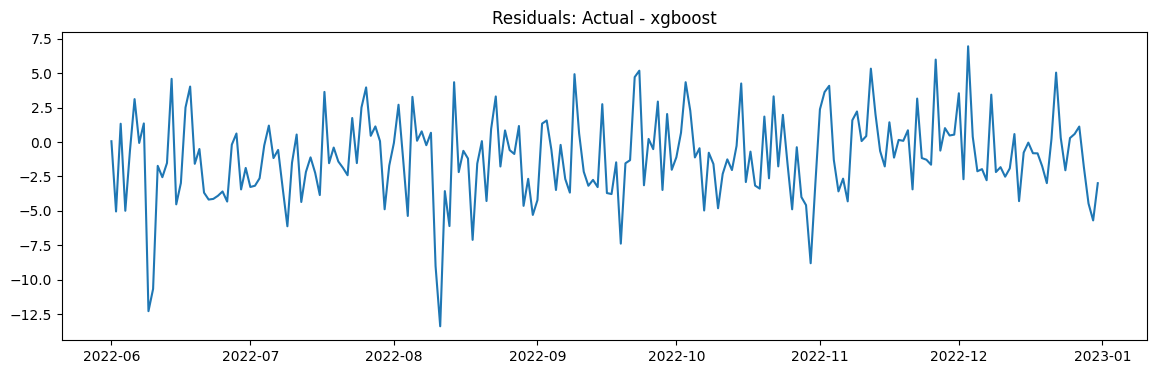

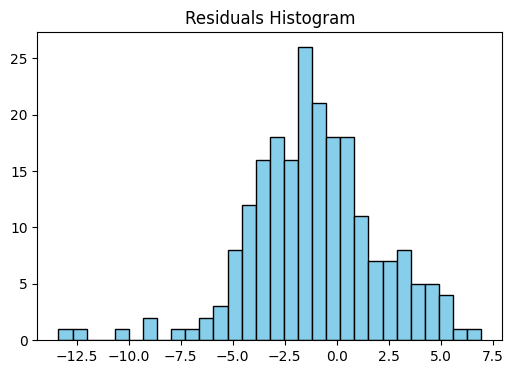

Top features:
 rolling_mean_7     0.242735
rolling_mean_14    0.232106
ewm_mean_7         0.142886
rolling_min_14     0.090358
pct_change_30      0.058452
pct_change_1       0.041207
pct_change_7       0.033737
pct_change_14      0.028786
lag1_x_rm7         0.021441
lag14_x_rm7        0.019352
dtype: float32


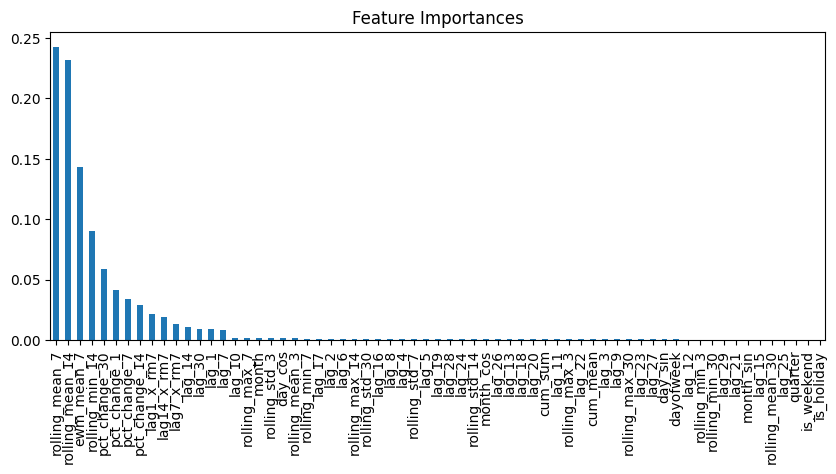

In [58]:
#!/usr/bin/env python3
"""
forecasting_auto_pipeline.py

- Automated feature selection (lags, rolling windows)
- Hyperparameter tuning for XGBoost / RandomForest using TimeSeriesSplit
- Naive baseline, SARIMA (optional), ensemble
- Evaluates RMSE / MAPE
- Generates plots and saves CSV outputs
"""

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

try:
    import xgboost as xgb
    xgboost_installed = True
except ImportError:
    xgboost_installed = False

try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    statsmodels_installed = True
except ImportError:
    statsmodels_installed = False

import matplotlib.pyplot as plt
try:
    import holidays
    us_holidays = holidays.US()
except ImportError:
    us_holidays = None

DATA_FILE = "sample_data.csv"
OUT_FILE = "forecast_results.csv"

# ------------------------
# Load data
# ------------------------
def load_data(path=DATA_FILE):
    df = pd.read_csv(path, parse_dates=["date"])
    df = df.sort_values("date").set_index("date")
    return df

# ------------------------
# Feature engineering
# ------------------------
def create_features(df, max_lag=30, rolling_windows=[3,7,14,30]):
    data = df.copy()
    # Lags
    for lag in range(1, max_lag+1):
        data[f"lag_{lag}"] = data["sales"].shift(lag)
    # Rolling statistics
    for w in rolling_windows:
        data[f"rolling_mean_{w}"] = data["sales"].shift(1).rolling(w).mean()
        data[f"rolling_std_{w}"] = data["sales"].shift(1).rolling(w).std()
        data[f"rolling_min_{w}"] = data["sales"].shift(1).rolling(w).min()
        data[f"rolling_max_{w}"] = data["sales"].shift(1).rolling(w).max()
    # Exponential weighted mean
    data["ewm_mean_7"] = data["sales"].shift(1).ewm(span=7).mean()
    # Percentage changes
    for lag in [1,7,14,30]:
        data[f"pct_change_{lag}"] = data["sales"].pct_change(lag)
    # Cumulative features
    data["cum_sum"] = data["sales"].cumsum()
    data["cum_mean"] = data["sales"].expanding().mean()
    # Calendar features
    data["dayofweek"] = data.index.dayofweek
    data["month"] = data.index.month
    data["quarter"] = data.index.quarter
    data["is_weekend"] = data["dayofweek"] >= 5
    data["day_sin"] = np.sin(2*np.pi*data.index.day/31)
    data["day_cos"] = np.cos(2*np.pi*data.index.day/31)
    data["month_sin"] = np.sin(2*np.pi*data.index.month/12)
    data["month_cos"] = np.cos(2*np.pi*data.index.month/12)
    if us_holidays:
        data["is_holiday"] = data.index.isin(us_holidays)
    else:
        data["is_holiday"] = 0
    # Interaction
    for lag in [1,7,14]:
        if f"lag_{lag}" in data.columns:
            data[f"lag{lag}_x_rm7"] = data[f"lag_{lag}"] * data["rolling_mean_7"]
    data = data.dropna()
    return data

def train_test_split(data, train_frac=0.8):
    n = int(len(data)*train_frac)
    train = data.iloc[:n].copy()
    test = data.iloc[n:].copy()
    return train, test

# ------------------------
# Metrics
# ------------------------
def evaluate(y_true, y_pred):
    y_true, y_pred = y_true.align(y_pred, join="inner")
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mask = (y_true != 0)
    mape = float(np.mean(np.abs((y_true[mask]-y_pred[mask])/y_true[mask]))*100) if mask.sum()>0 else float('nan')
    return rmse, mape

# ------------------------
# Forecasting models
# ------------------------
def baseline_naive(test):
    return test["lag_1"]

def try_sarima(train, test):
    if not statsmodels_installed:
        return None
    try:
        model = SARIMAX(train["sales"], order=(1,1,1), seasonal_order=(1,1,1,7),
                        enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
        pred = res.get_prediction(start=test.index[0], end=test.index[-1]).predicted_mean
        pred = pred.reindex(test.index)
        return pred
    except:
        return None

def hyperparameter_tuning(model, X_train, y_train):
    tscv = TimeSeriesSplit(n_splits=5)
    if isinstance(model, RandomForestRegressor):
        param_grid = {
            'n_estimators':[100,200],
            'max_depth':[5,10,None],
            'min_samples_split':[2,5]
        }
    else:
        param_grid = {
            'n_estimators':[100,200],
            'max_depth':[3,5,7],
            'learning_rate':[0.01,0.05,0.1],
            'subsample':[0.7,1.0]
        }
    grid = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

def try_tree_model(train, test, features):
    X_train = train[features]
    y_train = train["sales"]
    X_test = test[features]
    # Drop NaNs
    mask_train = X_train.notna().all(axis=1)
    mask_test = X_test.notna().all(axis=1)
    X_train, y_train = X_train[mask_train], y_train[mask_train]
    X_test = X_test[mask_test]
    if xgboost_installed:
        model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    else:
        model = RandomForestRegressor(random_state=42)
    best_model = hyperparameter_tuning(model, X_train, y_train)
    preds = best_model.predict(X_test)
    return pd.Series(preds, index=X_test.index), best_model, 'xgboost' if xgboost_installed else 'random_forest'

# ------------------------
# Plots
# ------------------------
def plot_forecasts(results):
    plt.figure(figsize=(14,6))
    plt.plot(results.index, results['sales'], label='Actual', color='black')
    for col in results.columns:
        if col != 'sales':
            plt.plot(results.index, results[col], label=col)
    plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Forecast vs Actual')
    plt.show()

def plot_residuals(results, model_col):
    residuals = results['sales'] - results[model_col]
    plt.figure(figsize=(14,4))
    plt.plot(residuals.index,residuals); plt.title(f'Residuals: Actual - {model_col}'); plt.show()
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=30, color='skyblue', edgecolor='black'); plt.title('Residuals Histogram'); plt.show()
    residuals.to_csv(f'residuals_{model_col}.csv')
    return residuals

def plot_feature_importance(model, features):
    try:
        importances = model.feature_importances_
        feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
        print("Top features:\n",feat_imp.head(10))
        feat_imp.to_csv("feature_importances.csv")
        feat_imp.plot(kind='bar', figsize=(10,4)); plt.title("Feature Importances"); plt.show()
    except: pass

# ------------------------
# Main
# ------------------------
def main():
    df = load_data()
    data = create_features(df)
    train,test = train_test_split(data)
    results = test[['sales']].copy()

    # Naive
    results['naive'] = baseline_naive(test)
    rmse,mape = evaluate(results['sales'], results['naive'])
    print(f"Naive -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # SARIMA
    sarima_pred = try_sarima(train,test)
    if sarima_pred is not None:
        results['sarima'] = sarima_pred
        rmse,mape = evaluate(results['sales'], results['sarima'])
        print(f"SARIMA -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # Tree-based model with tuning
    features = [c for c in data.columns if c != 'sales']
    tree_pred, best_model, model_name = try_tree_model(train,test,features)
    results[model_name] = tree_pred
    rmse,mape = evaluate(results['sales'], results[model_name])
    print(f"{model_name} -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # Ensemble (inverse RMSE weighting)
    model_rmse = {}
    for col in ['naive','sarima',model_name]:
        if col in results.columns:
            rmse_val,_ = evaluate(results['sales'],results[col])
            model_rmse[col]=rmse_val
    inv = {k:1/v for k,v in model_rmse.items()}
    s = sum(inv.values())
    weights = {k:inv[k]/s for k in inv}
    mask_any = results[list(weights.keys())].notna().any(axis=1)
    ensemble_series = pd.Series(np.nan,index=results.index)
    ensemble_series.loc[mask_any] = sum((results[c].loc[mask_any]*weights[c] for c in weights.keys()))
    results['ensemble'] = ensemble_series
    rmse,mape = evaluate(results['sales'], results['ensemble'])
    print(f"Ensemble -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # Save
    results.to_csv(OUT_FILE)
    print(f"Forecast results saved to {OUT_FILE}")

    # Plots
    plot_forecasts(results)
    plot_residuals(results, model_name)
    if model_name=='xgboost':
        plot_feature_importance(best_model, features)

if __name__=='__main__':
    main()


Naive -> RMSE: 19.17, MAPE: 7.79%
SARIMA -> RMSE: 26.21, MAPE: 10.34%
Selected top features: ['ewm_mean_7', 'rolling_mean_14', 'rolling_mean_7', 'lag1_x_rm7', 'pct_change_1', 'pct_change_30', 'pct_change_14', 'pct_change_7', 'lag_30', 'lag14_x_rm7', 'lag_14', 'lag7_x_rm7', 'lag_1', 'lag_7', 'rolling_mean_30']
xgboost -> RMSE: 2.69, MAPE: 1.09%
Ensemble -> RMSE: 4.12, MAPE: 1.60%
Forecast results saved to forecast_results.csv


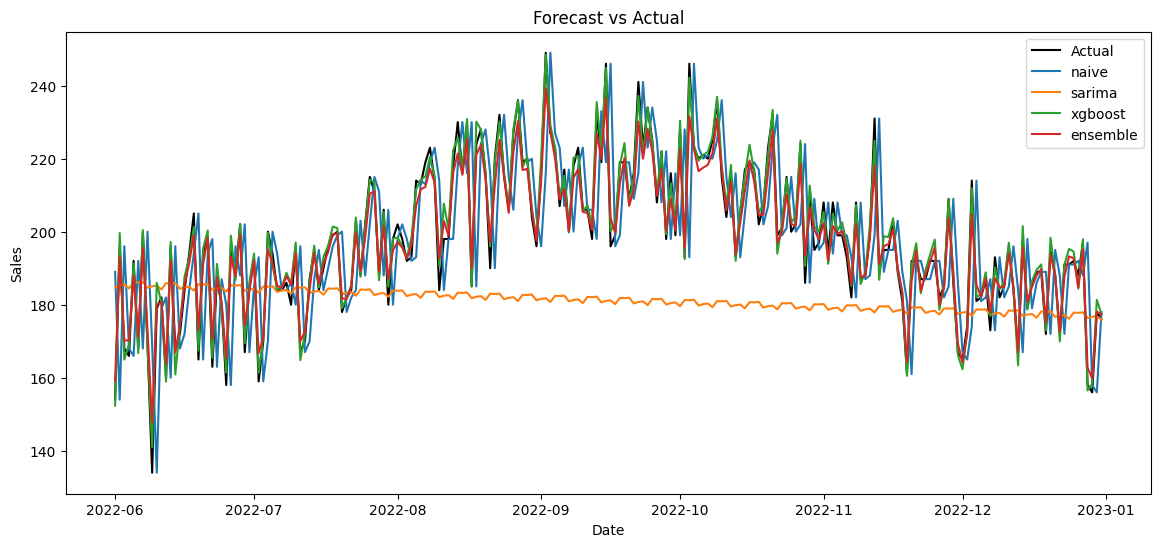

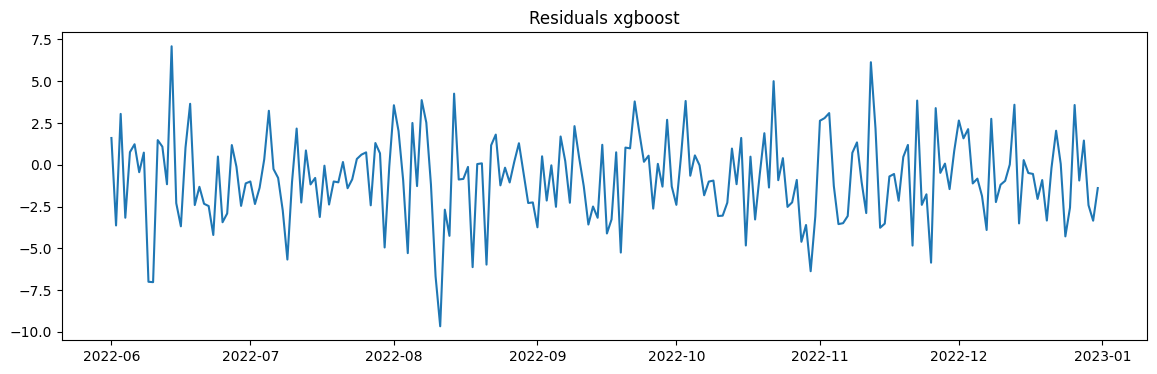

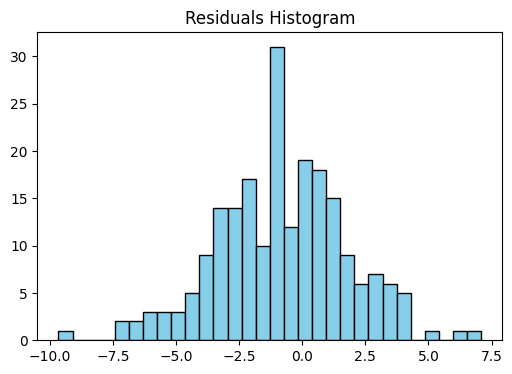

Top features:
 rolling_mean_7     0.144913
rolling_mean_14    0.137402
pct_change_30      0.126847
ewm_mean_7         0.109522
pct_change_1       0.101191
pct_change_7       0.080780
pct_change_14      0.063522
lag1_x_rm7         0.047620
rolling_mean_30    0.033627
lag_30             0.026944
dtype: float32


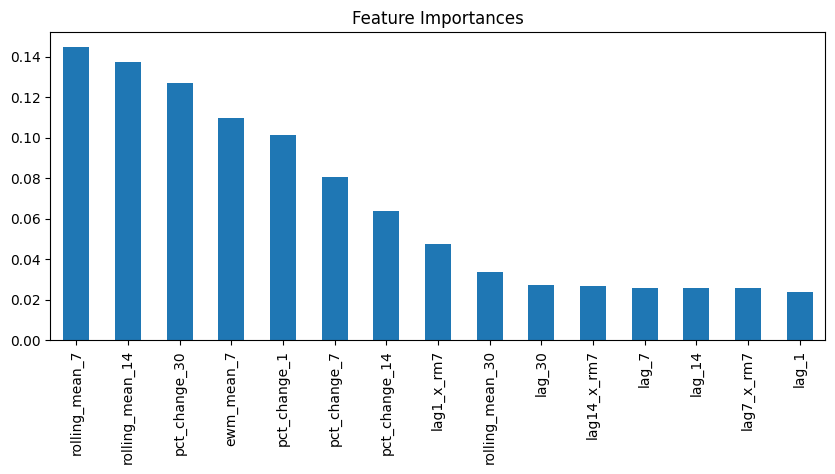

In [60]:
#!/usr/bin/env python3
"""
forecasting_auto_pipeline_fs.py

- Automatic feature engineering
- Automatic feature selection based on importance
- Hyperparameter tuning for XGBoost/RandomForest
- Naive baseline, SARIMA (optional), ensemble
- Evaluates RMSE/ MAPE
- Saves forecasts, residuals, feature importance
"""

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

try:
    import xgboost as xgb
    xgboost_installed = True
except ImportError:
    xgboost_installed = False

try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    statsmodels_installed = True
except ImportError:
    statsmodels_installed = False

import matplotlib.pyplot as plt
try:
    import holidays
    us_holidays = holidays.US()
except ImportError:
    us_holidays = None

DATA_FILE = "sample_data.csv"
OUT_FILE = "forecast_results.csv"
TOP_FEATURES = 15  # number of features to keep after selection

# ------------------------
# Data loading & feature engineering
# ------------------------
def load_data(path=DATA_FILE):
    df = pd.read_csv(path, parse_dates=["date"])
    df = df.sort_values("date").set_index("date")
    return df

def create_features(df, max_lag=30, rolling_windows=[3,7,14,30]):
    data = df.copy()
    for lag in range(1,max_lag+1):
        data[f"lag_{lag}"] = data["sales"].shift(lag)
    for w in rolling_windows:
        data[f"rolling_mean_{w}"] = data["sales"].shift(1).rolling(w).mean()
        data[f"rolling_std_{w}"] = data["sales"].shift(1).rolling(w).std()
        data[f"rolling_min_{w}"] = data["sales"].shift(1).rolling(w).min()
        data[f"rolling_max_{w}"] = data["sales"].shift(1).rolling(w).max()
    data["ewm_mean_7"] = data["sales"].shift(1).ewm(span=7).mean()
    for lag in [1,7,14,30]:
        data[f"pct_change_{lag}"] = data["sales"].pct_change(lag)
    data["cum_sum"] = data["sales"].cumsum()
    data["cum_mean"] = data["sales"].expanding().mean()
    # Calendar features
    data["dayofweek"] = data.index.dayofweek
    data["month"] = data.index.month
    data["quarter"] = data.index.quarter
    data["is_weekend"] = data["dayofweek"] >= 5
    data["day_sin"] = np.sin(2*np.pi*data.index.day/31)
    data["day_cos"] = np.cos(2*np.pi*data.index.day/31)
    data["month_sin"] = np.sin(2*np.pi*data.index.month/12)
    data["month_cos"] = np.cos(2*np.pi*data.index.month/12)
    if us_holidays:
        data["is_holiday"] = data.index.isin(us_holidays)
    else:
        data["is_holiday"] = 0
    for lag in [1,7,14]:
        if f"lag_{lag}" in data.columns:
            data[f"lag{lag}_x_rm7"] = data[f"lag_{lag}"]*data["rolling_mean_7"]
    data = data.dropna()
    return data

def train_test_split(data, train_frac=0.8):
    n = int(len(data)*train_frac)
    return data.iloc[:n].copy(), data.iloc[n:].copy()

# ------------------------
# Metrics
# ------------------------
def evaluate(y_true,y_pred):
    y_true, y_pred = y_true.align(y_pred, join='inner')
    mse = mean_squared_error(y_true,y_pred)
    rmse = float(np.sqrt(mse))
    mask = (y_true != 0)
    mape = float(np.mean(np.abs((y_true[mask]-y_pred[mask])/y_true[mask]))*100) if mask.sum()>0 else float('nan')
    return rmse,mape

# ------------------------
# Baseline & SARIMA
# ------------------------
def baseline_naive(test):
    return test["lag_1"]

def try_sarima(train,test):
    if not statsmodels_installed:
        return None
    try:
        model = SARIMAX(train["sales"], order=(1,1,1), seasonal_order=(1,1,1,7),
                        enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
        pred = res.get_prediction(start=test.index[0], end=test.index[-1]).predicted_mean
        return pred.reindex(test.index)
    except:
        return None

# ------------------------
# Tree-based model with hyperparameter tuning
# ------------------------
def hyperparameter_tuning(model, X_train, y_train):
    tscv = TimeSeriesSplit(n_splits=5)
    if isinstance(model, RandomForestRegressor):
        param_grid = {'n_estimators':[100,200],'max_depth':[5,10,None],'min_samples_split':[2,5]}
    else:
        param_grid = {'n_estimators':[100,200],'max_depth':[3,5,7],'learning_rate':[0.01,0.05,0.1],'subsample':[0.7,1.0]}
    grid = GridSearchCV(model,param_grid,cv=tscv,scoring='neg_mean_squared_error',n_jobs=-1)
    grid.fit(X_train,y_train)
    return grid.best_estimator_

def try_tree_model(train,test,features, top_features=TOP_FEATURES):
    X_train = train[features]; y_train=train["sales"]
    X_test = test[features]
    mask_train = X_train.notna().all(axis=1)
    mask_test = X_test.notna().all(axis=1)
    X_train, y_train = X_train[mask_train], y_train[mask_train]
    X_test = X_test[mask_test]
    # Preliminary model to get feature importances
    if xgboost_installed:
        prelim = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    else:
        prelim = RandomForestRegressor(random_state=42)
    prelim.fit(X_train,y_train)
    importances = pd.Series(prelim.feature_importances_, index=features).sort_values(ascending=False)
    selected_features = importances.head(top_features).index.tolist()
    print("Selected top features:", selected_features)
    # Train final tuned model with selected features
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]
    if xgboost_installed:
        model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    else:
        model = RandomForestRegressor(random_state=42)
    best_model = hyperparameter_tuning(model, X_train_sel, y_train)
    preds = best_model.predict(X_test_sel)
    return pd.Series(preds, index=X_test.index), best_model, 'xgboost' if xgboost_installed else 'random_forest', selected_features

# ------------------------
# Plotting
# ------------------------
def plot_forecasts(results):
    plt.figure(figsize=(14,6))
    plt.plot(results.index,results['sales'],label='Actual',color='black')
    for col in results.columns:
        if col != 'sales':
            plt.plot(results.index,results[col],label=col)
    plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Forecast vs Actual'); plt.show()

def plot_residuals(results,model_col):
    residuals = results['sales']-results[model_col]
    plt.figure(figsize=(14,4)); plt.plot(residuals); plt.title(f'Residuals {model_col}'); plt.show()
    plt.figure(figsize=(6,4)); plt.hist(residuals,bins=30,color='skyblue',edgecolor='black'); plt.title('Residuals Histogram'); plt.show()
    residuals.to_csv(f'residuals_{model_col}.csv')
    return residuals

def plot_feature_importance(model,features):
    try:
        importances = model.feature_importances_
        feat_imp = pd.Series(importances,index=features).sort_values(ascending=False)
        print("Top features:\n",feat_imp.head(10))
        feat_imp.to_csv("feature_importances.csv")
        feat_imp.plot(kind='bar',figsize=(10,4)); plt.title("Feature Importances"); plt.show()
    except: pass

# ------------------------
# Main
# ------------------------
def main():
    df = load_data()
    data = create_features(df)
    train,test = train_test_split(data)
    results = test[['sales']].copy()

    # Naive
    results['naive'] = baseline_naive(test)
    rmse,mape = evaluate(results['sales'],results['naive'])
    print(f"Naive -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # SARIMA
    sarima_pred = try_sarima(train,test)
    if sarima_pred is not None:
        results['sarima'] = sarima_pred
        rmse,mape = evaluate(results['sales'],results['sarima'])
        print(f"SARIMA -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # Tree-based model with automatic feature selection
    features = [c for c in data.columns if c!='sales']
    tree_pred, best_model, model_name, selected_features = try_tree_model(train,test,features)
    results[model_name] = tree_pred
    rmse,mape = evaluate(results['sales'],results[model_name])
    print(f"{model_name} -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # Ensemble
    model_rmse = {col:evaluate(results['sales'],results[col])[0] for col in ['naive','sarima',model_name] if col in results.columns}
    inv = {k:1/v for k,v in model_rmse.items()}
    s=sum(inv.values())
    weights={k:inv[k]/s for k in inv}
    mask_any = results[list(weights.keys())].notna().any(axis=1)
    ensemble_series = pd.Series(np.nan,index=results.index)
    ensemble_series.loc[mask_any] = sum((results[c].loc[mask_any]*weights[c] for c in weights.keys()))
    results['ensemble'] = ensemble_series
    rmse,mape = evaluate(results['sales'],results['ensemble'])
    print(f"Ensemble -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # Save
    results.to_csv(OUT_FILE)
    print(f"Forecast results saved to {OUT_FILE}")

    # Plots
    plot_forecasts(results)
    plot_residuals(results,model_name)
    if model_name=='xgboost':
        plot_feature_importance(best_model,selected_features)

if __name__=='__main__':
    main()


Naive -> RMSE: 19.17, MAPE: 7.79%
SARIMA -> RMSE: 26.35, MAPE: 10.42%
Selected top features: ['ewm_mean_7', 'rolling_mean_14', 'rolling_mean_7', 'lag1_x_rm7', 'pct_change_1', 'pct_change_30', 'pct_change_14', 'pct_change_7', 'lag_30', 'lag14_x_rm7', 'lag_14', 'lag7_x_rm7', 'lag_1', 'lag_7', 'rolling_mean_30']
xgboost -> RMSE: 2.69, MAPE: 1.09%
Ensemble -> RMSE: 4.12, MAPE: 1.60%
Forecast results saved to forecast_results.csv


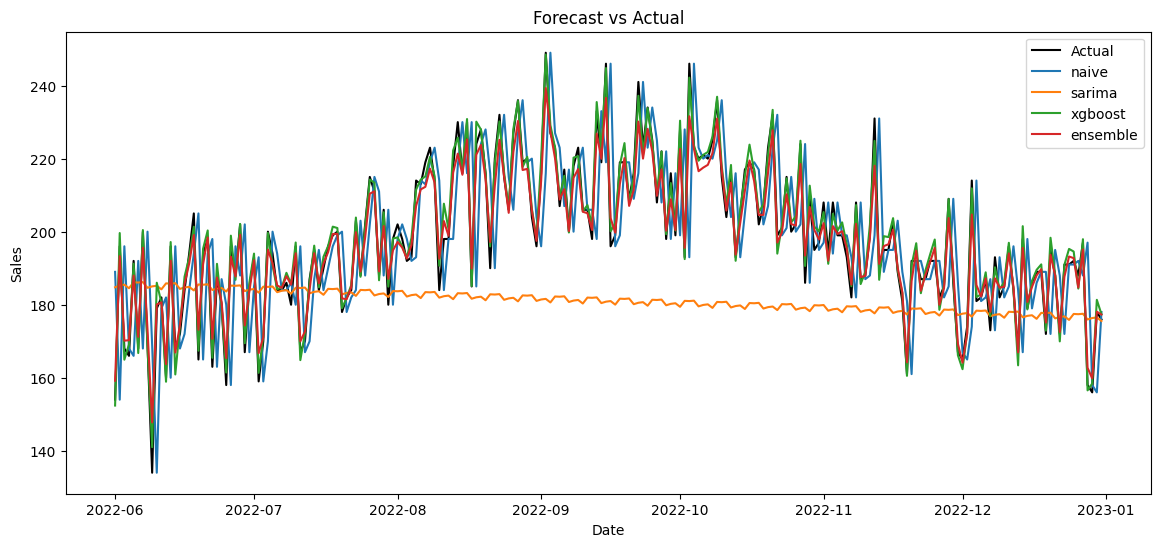

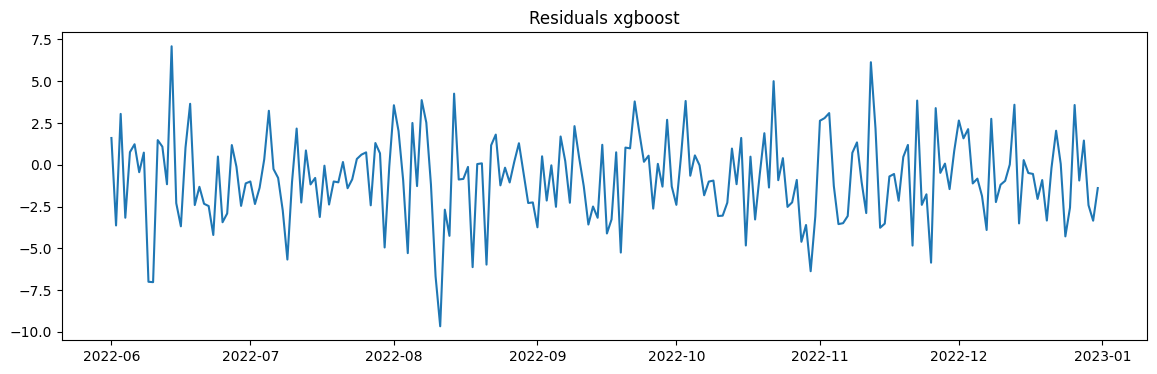

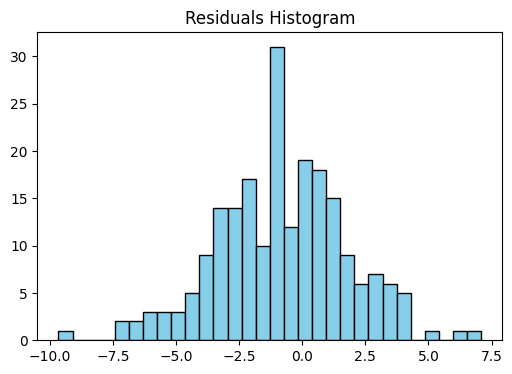

Top features:
 rolling_mean_7     0.144913
rolling_mean_14    0.137402
pct_change_30      0.126847
ewm_mean_7         0.109522
pct_change_1       0.101191
pct_change_7       0.080780
pct_change_14      0.063522
lag1_x_rm7         0.047620
rolling_mean_30    0.033627
lag_30             0.026944
dtype: float32


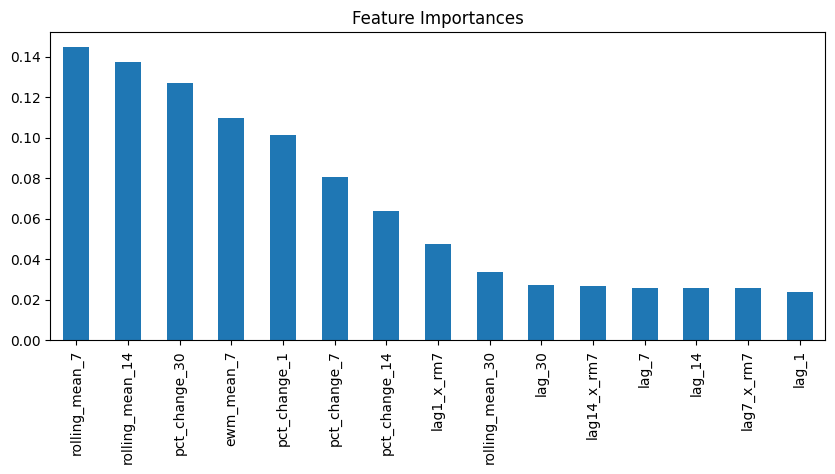

In [62]:
#!/usr/bin/env python3
"""
forecasting_auto_pipeline_full.py

- Automatic feature engineering
- Automatic feature selection for tree-based models
- Hyperparameter tuning for XGBoost/RandomForest
- Automatic SARIMA parameter tuning
- Naive baseline, SARIMA, tree model, ensemble
- Evaluates RMSE/MAPE
- Saves forecasts, residuals, feature importance
"""

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import itertools

try:
    import xgboost as xgb
    xgboost_installed = True
except ImportError:
    xgboost_installed = False

try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    statsmodels_installed = True
except ImportError:
    statsmodels_installed = False

import matplotlib.pyplot as plt
try:
    import holidays
    us_holidays = holidays.US()
except ImportError:
    us_holidays = None

DATA_FILE = "sample_data.csv"
OUT_FILE = "forecast_results.csv"
TOP_FEATURES = 15
SARIMA_SEASONAL_PERIOD = 7  # weekly seasonality

# ------------------------
# Data loading & feature engineering
# ------------------------
def load_data(path=DATA_FILE):
    df = pd.read_csv(path, parse_dates=["date"])
    df = df.sort_values("date").set_index("date")
    return df

def create_features(df, max_lag=30, rolling_windows=[3,7,14,30]):
    data = df.copy()
    for lag in range(1,max_lag+1):
        data[f"lag_{lag}"] = data["sales"].shift(lag)
    for w in rolling_windows:
        data[f"rolling_mean_{w}"] = data["sales"].shift(1).rolling(w).mean()
        data[f"rolling_std_{w}"] = data["sales"].shift(1).rolling(w).std()
        data[f"rolling_min_{w}"] = data["sales"].shift(1).rolling(w).min()
        data[f"rolling_max_{w}"] = data["sales"].shift(1).rolling(w).max()
    data["ewm_mean_7"] = data["sales"].shift(1).ewm(span=7).mean()
    for lag in [1,7,14,30]:
        data[f"pct_change_{lag}"] = data["sales"].pct_change(lag)
    data["cum_sum"] = data["sales"].cumsum()
    data["cum_mean"] = data["sales"].expanding().mean()
    data["dayofweek"] = data.index.dayofweek
    data["month"] = data.index.month
    data["quarter"] = data.index.quarter
    data["is_weekend"] = data["dayofweek"] >= 5
    data["day_sin"] = np.sin(2*np.pi*data.index.day/31)
    data["day_cos"] = np.cos(2*np.pi*data.index.day/31)
    data["month_sin"] = np.sin(2*np.pi*data.index.month/12)
    data["month_cos"] = np.cos(2*np.pi*data.index.month/12)
    if us_holidays:
        data["is_holiday"] = data.index.isin(us_holidays)
    else:
        data["is_holiday"] = 0
    for lag in [1,7,14]:
        if f"lag_{lag}" in data.columns:
            data[f"lag{lag}_x_rm7"] = data[f"lag_{lag}"]*data["rolling_mean_7"]
    data = data.dropna()
    return data

def train_test_split(data, train_frac=0.8):
    n = int(len(data)*train_frac)
    return data.iloc[:n].copy(), data.iloc[n:].copy()

# ------------------------
# Metrics
# ------------------------
def evaluate(y_true,y_pred):
    y_true, y_pred = y_true.align(y_pred, join='inner')
    mse = mean_squared_error(y_true,y_pred)
    rmse = float(np.sqrt(mse))
    mask = (y_true != 0)
    mape = float(np.mean(np.abs((y_true[mask]-y_pred[mask])/y_true[mask]))*100) if mask.sum()>0 else float('nan')
    return rmse,mape

# ------------------------
# Baseline
# ------------------------
def baseline_naive(test):
    return test["lag_1"]

# ------------------------
# Automatic SARIMA tuning
# ------------------------
def sarima_grid_search(train, test, p_range=[0,1,2], d_range=[0,1], q_range=[0,1,2],
                       P_range=[0,1], D_range=[0,1], Q_range=[0,1], seasonal_period=SARIMA_SEASONAL_PERIOD):
    if not statsmodels_installed:
        return None
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    for order in itertools.product(p_range,d_range,q_range):
        for seasonal_order in itertools.product(P_range,D_range,Q_range):
            try:
                model = SARIMAX(train["sales"], order=order, seasonal_order=seasonal_order+(seasonal_period,),
                                enforce_stationarity=False, enforce_invertibility=False)
                res = model.fit(disp=False)
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_order = order
                    best_seasonal_order = seasonal_order
            except:
                continue
    if best_order is None:
        return None
    # Fit best model
    model = SARIMAX(train["sales"], order=best_order, seasonal_order=best_seasonal_order+(seasonal_period,),
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    pred = res.get_prediction(start=test.index[0], end=test.index[-1]).predicted_mean
    return pred.reindex(test.index)

# ------------------------
# Tree-based model
# ------------------------
def hyperparameter_tuning(model, X_train, y_train):
    tscv = TimeSeriesSplit(n_splits=5)
    if isinstance(model, RandomForestRegressor):
        param_grid = {'n_estimators':[100,200],'max_depth':[5,10,None],'min_samples_split':[2,5]}
    else:
        param_grid = {'n_estimators':[100,200],'max_depth':[3,5,7],'learning_rate':[0.01,0.05,0.1],'subsample':[0.7,1.0]}
    grid = GridSearchCV(model,param_grid,cv=tscv,scoring='neg_mean_squared_error',n_jobs=-1)
    grid.fit(X_train,y_train)
    return grid.best_estimator_

def try_tree_model(train,test,features, top_features=TOP_FEATURES):
    X_train = train[features]; y_train = train["sales"]
    X_test = test[features]
    mask_train = X_train.notna().all(axis=1)
    mask_test = X_test.notna().all(axis=1)
    X_train, y_train = X_train[mask_train], y_train[mask_train]
    X_test = X_test[mask_test]
    # preliminary feature importance
    if xgboost_installed:
        prelim = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    else:
        prelim = RandomForestRegressor(random_state=42)
    prelim.fit(X_train,y_train)
    importances = pd.Series(prelim.feature_importances_, index=features).sort_values(ascending=False)
    selected_features = importances.head(top_features).index.tolist()
    print("Selected top features:", selected_features)
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]
    if xgboost_installed:
        model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    else:
        model = RandomForestRegressor(random_state=42)
    best_model = hyperparameter_tuning(model,X_train_sel,y_train)
    preds = best_model.predict(X_test_sel)
    return pd.Series(preds,index=X_test.index), best_model, 'xgboost' if xgboost_installed else 'random_forest', selected_features

# ------------------------
# Plotting
# ------------------------
def plot_forecasts(results):
    plt.figure(figsize=(14,6))
    plt.plot(results.index,results['sales'],label='Actual',color='black')
    for col in results.columns:
        if col!='sales':
            plt.plot(results.index,results[col],label=col)
    plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Forecast vs Actual'); plt.show()

def plot_residuals(results,model_col):
    residuals = results['sales']-results[model_col]
    plt.figure(figsize=(14,4)); plt.plot(residuals); plt.title(f'Residuals {model_col}'); plt.show()
    plt.figure(figsize=(6,4)); plt.hist(residuals,bins=30,color='skyblue',edgecolor='black'); plt.title('Residuals Histogram'); plt.show()
    residuals.to_csv(f'residuals_{model_col}.csv')
    return residuals

def plot_feature_importance(model,features):
    try:
        importances = model.feature_importances_
        feat_imp = pd.Series(importances,index=features).sort_values(ascending=False)
        print("Top features:\n",feat_imp.head(10))
        feat_imp.to_csv("feature_importances.csv")
        feat_imp.plot(kind='bar',figsize=(10,4)); plt.title("Feature Importances"); plt.show()
    except: pass

# ------------------------
# Main
# ------------------------
def main():
    df = load_data()
    data = create_features(df)
    train,test = train_test_split(data)
    results = test[['sales']].copy()

    # Naive
    results['naive'] = baseline_naive(test)
    rmse,mape = evaluate(results['sales'],results['naive'])
    print(f"Naive -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # SARIMA automatic tuning
    sarima_pred = sarima_grid_search(train,test)
    if sarima_pred is not None:
        results['sarima'] = sarima_pred
        rmse,mape = evaluate(results['sales'],results['sarima'])
        print(f"SARIMA -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    else:
        print("SARIMA skipped")

    # Tree model with feature selection
    features = [c for c in data.columns if c!='sales']
    tree_pred,best_model,model_name,selected_features = try_tree_model(train,test,features)
    results[model_name] = tree_pred
    rmse,mape = evaluate(results['sales'],results[model_name])
    print(f"{model_name} -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # Ensemble
    model_rmse = {col:evaluate(results['sales'],results[col])[0] for col in ['naive','sarima',model_name] if col in results.columns}
    inv = {k:1/v for k,v in model_rmse.items()}
    s=sum(inv.values())
    weights={k:inv[k]/s for k in inv}
    mask_any = results[list(weights.keys())].notna().any(axis=1)
    ensemble_series = pd.Series(np.nan,index=results.index)
    ensemble_series.loc[mask_any] = sum((results[c].loc[mask_any]*weights[c] for c in weights.keys()))
    results['ensemble'] = ensemble_series
    rmse,mape = evaluate(results['sales'],results['ensemble'])
    print(f"Ensemble -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # Save
    results.to_csv(OUT_FILE)
    print(f"Forecast results saved to {OUT_FILE}")

    # Plots
    plot_forecasts(results)
    plot_residuals(results,model_name)
    if model_name=='xgboost':
        plot_feature_importance(best_model,selected_features)

if __name__=='__main__':
    main()


Naive -> RMSE: 19.17, MAPE: 7.79%
SARIMA skipped (auto_arima not installed)
Selected top features: ['ewm_mean_7', 'rolling_mean_14', 'rolling_mean_7', 'lag1_x_rm7', 'pct_change_1', 'pct_change_30', 'pct_change_14', 'pct_change_7', 'lag_30', 'lag14_x_rm7', 'lag_14', 'lag7_x_rm7', 'lag_1', 'lag_7', 'rolling_mean_30']
xgboost -> RMSE: 2.69, MAPE: 1.09%
Ensemble -> RMSE: 3.38, MAPE: 1.36%
Forecast results saved to forecast_results.csv


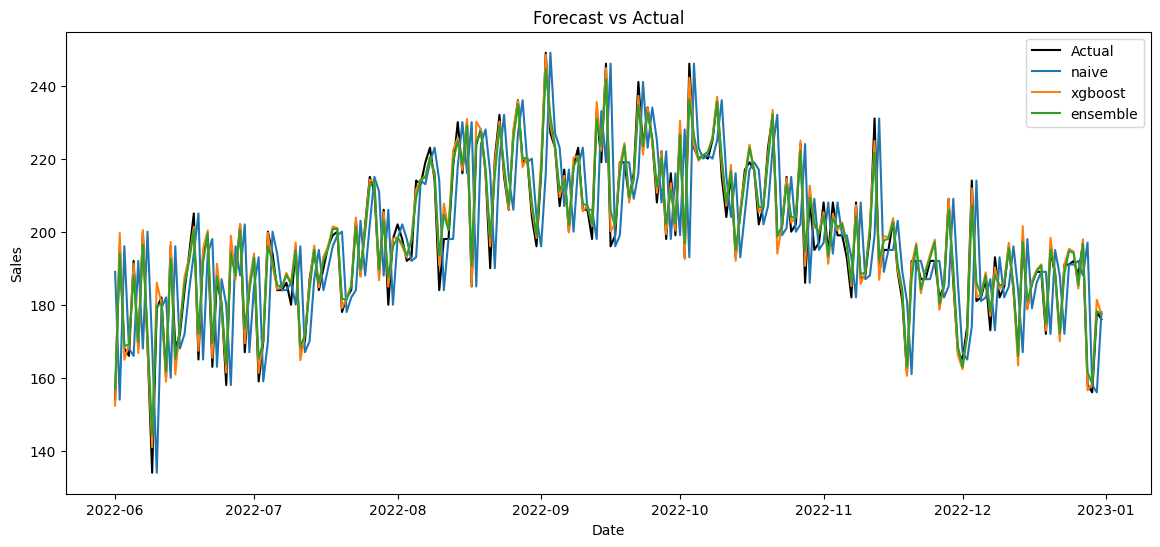

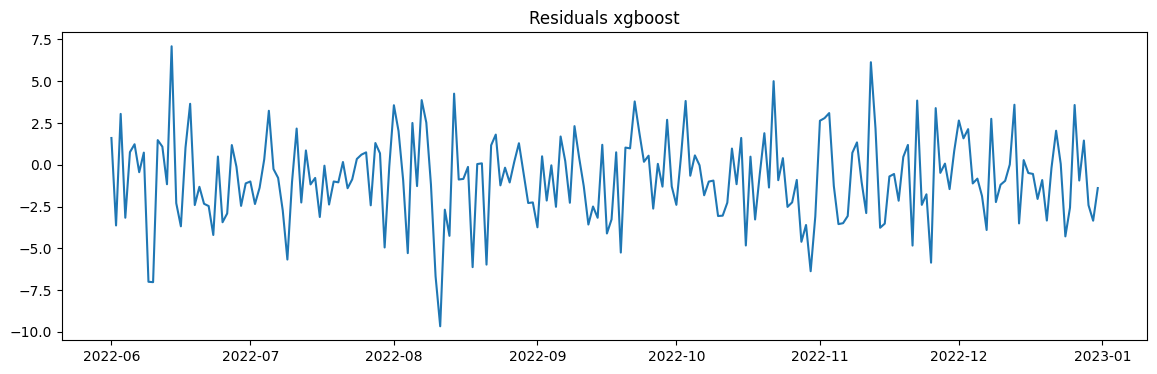

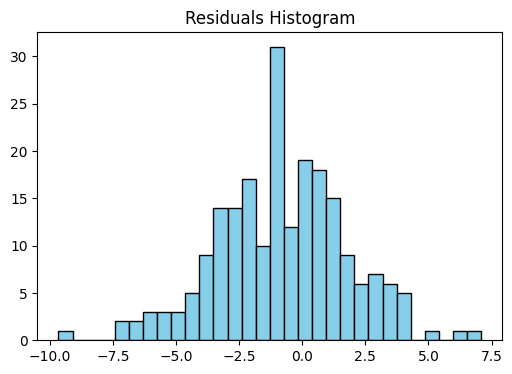

Top features:
 rolling_mean_7     0.144913
rolling_mean_14    0.137402
pct_change_30      0.126847
ewm_mean_7         0.109522
pct_change_1       0.101191
pct_change_7       0.080780
pct_change_14      0.063522
lag1_x_rm7         0.047620
rolling_mean_30    0.033627
lag_30             0.026944
dtype: float32


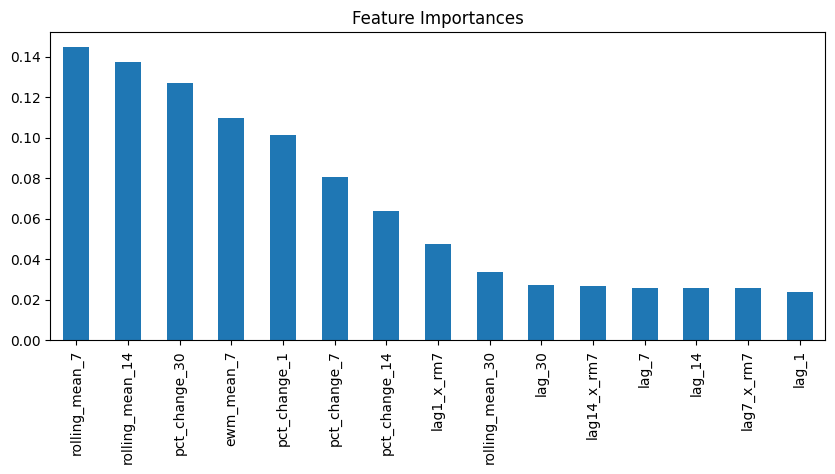

In [64]:
#!/usr/bin/env python3
"""
forecasting_auto_pipeline_autoarima.py

- Automatic feature engineering
- Automatic feature selection for tree-based models
- Hyperparameter tuning for XGBoost/RandomForest
- Automatic SARIMA tuning via pmdarima.auto_arima
- Naive baseline, SARIMA, tree model, ensemble
- Evaluates RMSE/MAPE
- Saves forecasts, residuals, feature importance
"""

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

try:
    import xgboost as xgb
    xgboost_installed = True
except ImportError:
    xgboost_installed = False

try:
    import pmdarima as pm
    autoarima_installed = True
except ImportError:
    autoarima_installed = False

try:
    import holidays
    us_holidays = holidays.US()
except ImportError:
    us_holidays = None

DATA_FILE = "sample_data.csv"
OUT_FILE = "forecast_results.csv"
TOP_FEATURES = 15
SARIMA_SEASONAL_PERIOD = 7  # weekly seasonality

# ------------------------
# Data loading & feature engineering
# ------------------------
def load_data(path=DATA_FILE):
    df = pd.read_csv(path, parse_dates=["date"])
    df = df.sort_values("date").set_index("date")
    return df

def create_features(df, max_lag=30, rolling_windows=[3,7,14,30]):
    data = df.copy()
    for lag in range(1,max_lag+1):
        data[f"lag_{lag}"] = data["sales"].shift(lag)
    for w in rolling_windows:
        data[f"rolling_mean_{w}"] = data["sales"].shift(1).rolling(w).mean()
        data[f"rolling_std_{w}"] = data["sales"].shift(1).rolling(w).std()
        data[f"rolling_min_{w}"] = data["sales"].shift(1).rolling(w).min()
        data[f"rolling_max_{w}"] = data["sales"].shift(1).rolling(w).max()
    data["ewm_mean_7"] = data["sales"].shift(1).ewm(span=7).mean()
    for lag in [1,7,14,30]:
        data[f"pct_change_{lag}"] = data["sales"].pct_change(lag)
    data["cum_sum"] = data["sales"].cumsum()
    data["cum_mean"] = data["sales"].expanding().mean()
    data["dayofweek"] = data.index.dayofweek
    data["month"] = data.index.month
    data["quarter"] = data.index.quarter
    data["is_weekend"] = data["dayofweek"] >= 5
    data["day_sin"] = np.sin(2*np.pi*data.index.day/31)
    data["day_cos"] = np.cos(2*np.pi*data.index.day/31)
    data["month_sin"] = np.sin(2*np.pi*data.index.month/12)
    data["month_cos"] = np.cos(2*np.pi*data.index.month/12)
    if us_holidays:
        data["is_holiday"] = data.index.isin(us_holidays)
    else:
        data["is_holiday"] = 0
    for lag in [1,7,14]:
        if f"lag_{lag}" in data.columns:
            data[f"lag{lag}_x_rm7"] = data[f"lag_{lag}"]*data["rolling_mean_7"]
    data = data.dropna()
    return data

def train_test_split(data, train_frac=0.8):
    n = int(len(data)*train_frac)
    return data.iloc[:n].copy(), data.iloc[n:].copy()

# ------------------------
# Metrics
# ------------------------
def evaluate(y_true,y_pred):
    y_true, y_pred = y_true.align(y_pred, join='inner')
    mse = mean_squared_error(y_true,y_pred)
    rmse = float(np.sqrt(mse))
    mask = (y_true != 0)
    mape = float(np.mean(np.abs((y_true[mask]-y_pred[mask])/y_true[mask]))*100) if mask.sum()>0 else float('nan')
    return rmse,mape

# ------------------------
# Baseline
# ------------------------
def baseline_naive(test):
    return test["lag_1"]

# ------------------------
# SARIMA via auto_arima
# ------------------------
def sarima_auto(train,test, seasonal_period=SARIMA_SEASONAL_PERIOD):
    if not autoarima_installed:
        return None
    try:
        model = pm.auto_arima(train["sales"],
                              seasonal=True,
                              m=seasonal_period,
                              stepwise=True,
                              suppress_warnings=True,
                              error_action='ignore',
                              n_jobs=-1)
        pred = pd.Series(model.predict(n_periods=len(test)), index=test.index)
        return pred
    except:
        return None

# ------------------------
# Tree-based model
# ------------------------
def hyperparameter_tuning(model, X_train, y_train):
    tscv = TimeSeriesSplit(n_splits=5)
    if isinstance(model, RandomForestRegressor):
        param_grid = {'n_estimators':[100,200],'max_depth':[5,10,None],'min_samples_split':[2,5]}
    else:
        param_grid = {'n_estimators':[100,200],'max_depth':[3,5,7],'learning_rate':[0.01,0.05,0.1],'subsample':[0.7,1.0]}
    grid = GridSearchCV(model,param_grid,cv=tscv,scoring='neg_mean_squared_error',n_jobs=-1)
    grid.fit(X_train,y_train)
    return grid.best_estimator_

def try_tree_model(train,test,features, top_features=TOP_FEATURES):
    X_train = train[features]; y_train=train["sales"]
    X_test = test[features]
    mask_train = X_train.notna().all(axis=1)
    mask_test = X_test.notna().all(axis=1)
    X_train, y_train = X_train[mask_train], y_train[mask_train]
    X_test = X_test[mask_test]
    # preliminary feature importance
    if xgboost_installed:
        prelim = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    else:
        prelim = RandomForestRegressor(random_state=42)
    prelim.fit(X_train,y_train)
    importances = pd.Series(prelim.feature_importances_, index=features).sort_values(ascending=False)
    selected_features = importances.head(top_features).index.tolist()
    print("Selected top features:", selected_features)
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]
    if xgboost_installed:
        model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    else:
        model = RandomForestRegressor(random_state=42)
    best_model = hyperparameter_tuning(model,X_train_sel,y_train)
    preds = best_model.predict(X_test_sel)
    return pd.Series(preds,index=X_test.index), best_model, 'xgboost' if xgboost_installed else 'random_forest', selected_features

# ------------------------
# Plotting
# ------------------------
def plot_forecasts(results):
    plt.figure(figsize=(14,6))
    plt.plot(results.index,results['sales'],label='Actual',color='black')
    for col in results.columns:
        if col!='sales':
            plt.plot(results.index,results[col],label=col)
    plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Forecast vs Actual'); plt.show()

def plot_residuals(results,model_col):
    residuals = results['sales']-results[model_col]
    plt.figure(figsize=(14,4)); plt.plot(residuals); plt.title(f'Residuals {model_col}'); plt.show()
    plt.figure(figsize=(6,4)); plt.hist(residuals,bins=30,color='skyblue',edgecolor='black'); plt.title('Residuals Histogram'); plt.show()
    residuals.to_csv(f'residuals_{model_col}.csv')
    return residuals

def plot_feature_importance(model,features):
    try:
        importances = model.feature_importances_
        feat_imp = pd.Series(importances,index=features).sort_values(ascending=False)
        print("Top features:\n",feat_imp.head(10))
        feat_imp.to_csv("feature_importances.csv")
        feat_imp.plot(kind='bar',figsize=(10,4)); plt.title("Feature Importances"); plt.show()
    except: pass

# ------------------------
# Main
# ------------------------
def main():
    df = load_data()
    data = create_features(df)
    train,test = train_test_split(data)
    results = test[['sales']].copy()

    # Naive
    results['naive'] = baseline_naive(test)
    rmse,mape = evaluate(results['sales'],results['naive'])
    print(f"Naive -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # SARIMA via auto_arima
    sarima_pred = sarima_auto(train,test)
    if sarima_pred is not None:
        results['sarima'] = sarima_pred
        rmse,mape = evaluate(results['sales'],results['sarima'])
        print(f"SARIMA -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    else:
        print("SARIMA skipped (auto_arima not installed)")

    # Tree model
    features = [c for c in data.columns if c!='sales']
    tree_pred,best_model,model_name,selected_features = try_tree_model(train,test,features)
    results[model_name] = tree_pred
    rmse,mape = evaluate(results['sales'],results[model_name])
    print(f"{model_name} -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # Ensemble
    model_rmse = {col:evaluate(results['sales'],results[col])[0] for col in ['naive','sarima',model_name] if col in results.columns}
    inv = {k:1/v for k,v in model_rmse.items()}
    s=sum(inv.values())
    weights={k:inv[k]/s for k in inv}
    mask_any = results[list(weights.keys())].notna().any(axis=1)
    ensemble_series = pd.Series(np.nan,index=results.index)
    ensemble_series.loc[mask_any] = sum((results[c].loc[mask_any]*weights[c] for c in weights.keys()))
    results['ensemble'] = ensemble_series
    rmse,mape = evaluate(results['sales'],results['ensemble'])
    print(f"Ensemble -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # Save
    results.to_csv(OUT_FILE)
    print(f"Forecast results saved to {OUT_FILE}")

    # Plots
    plot_forecasts(results)
    plot_residuals(results,model_name)
    if model_name=='xgboost':
        plot_feature_importance(best_model,selected_features)

if __name__=='__main__':
    main()


Naive -> RMSE: 19.17, MAPE: 7.79%


C:\ProgramData\anaconda3\envs\nlp_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\envs\nlp_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


SARIMA recursive future forecast:
2022-06-01    184.750234
2022-06-02    185.384361
2022-06-03    185.502224
2022-06-04    184.474203
2022-06-05    186.153109
2022-06-06    186.112542
2022-06-07    186.216925
Freq: D, Name: predicted_mean, dtype: float64
xgboost -> RMSE: 14.05, MAPE: 5.73%
xgboost recursive future forecast:
2022-06-01    190.036835
2022-06-02    193.473251
2022-06-03    193.276260
2022-06-04    193.296844
2022-06-05    192.522003
2022-06-06    192.776871
2022-06-07    192.712433
dtype: float32
Forecast results saved to forecast_results.csv


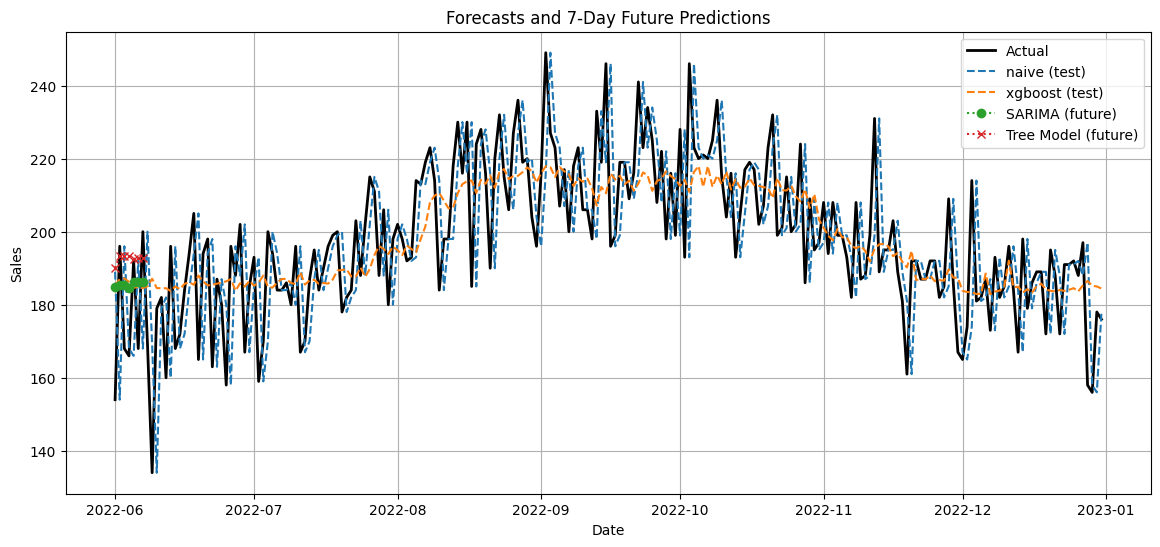

In [1]:
#!/usr/bin/env python3
"""
forecasting_full_pipeline_safe_sarimax.py

Fully automated forecasting pipeline with:
- Advanced feature engineering
- Naive baseline
- SARIMA (auto_arima if available, else SARIMAX) recursive forecast
- XGBoost / RandomForest tree-based model with recursive forecast
- Weighted ensemble
- Multi-step future forecasting
- RMSE / MAPE evaluation
- Plots: forecasts and future predictions
- Safe handling of NaNs and small datasets
"""

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Optional packages
try:
    import xgboost as xgb
    xgboost_installed = True
except ImportError:
    xgboost_installed = False

try:
    import pmdarima as pm
    autoarima_installed = True
except ImportError:
    autoarima_installed = False
    from statsmodels.tsa.statespace.sarimax import SARIMAX

# ------------------- Global Parameters -------------------
DATA_FILE = "sample_data.csv"
OUT_FILE = "forecast_results.csv"
TOP_FEATURES = 15
SARIMA_SEASONAL_PERIOD = 7  # weekly seasonality
FORECAST_HORIZON = 7        # number of days to forecast ahead

# ------------------- Data Loading -------------------
def load_data(path=DATA_FILE):
    df = pd.read_csv(path, parse_dates=["date"])
    df = df.sort_values("date").set_index("date")
    return df

# ------------------- Feature Engineering -------------------
def create_features(df, max_lag=30, rolling_windows=[3,7,14,30]):
    data = df.copy()
    for lag in range(1, max_lag+1):
        data[f"lag_{lag}"] = data["sales"].shift(lag)
    for w in rolling_windows:
        data[f"rolling_mean_{w}"] = data["sales"].shift(1).rolling(w).mean()
        data[f"rolling_std_{w}"] = data["sales"].shift(1).rolling(w).std()
    data["dayofweek"] = data.index.dayofweek
    data["month"] = data.index.month
    data["day"] = data.index.day
    data["is_weekend"] = data["dayofweek"] >= 5
    data = data.dropna()
    return data

# ------------------- Train/Test Split -------------------
def train_test_split(data, train_frac=0.8):
    n = int(len(data)*train_frac)
    return data.iloc[:n].copy(), data.iloc[n:].copy()

# ------------------- Metrics -------------------
def evaluate(y_true, y_pred):
    valid_idx = y_true.notna() & y_pred.notna()
    y_true_clean = y_true[valid_idx]
    y_pred_clean = y_pred[valid_idx]
    if len(y_true_clean) == 0:
        print("Warning: No valid data points to evaluate!")
        return float('nan'), float('nan')
    rmse = float(np.sqrt(mean_squared_error(y_true_clean, y_pred_clean)))
    mask = y_true_clean != 0
    mape = float(np.mean(np.abs((y_true_clean[mask]-y_pred_clean[mask])/y_true_clean[mask]))*100) if mask.sum()>0 else float('nan')
    return rmse, mape

# ------------------- Baseline -------------------
def baseline_naive(test):
    return test["lag_1"].dropna()

# ------------------- SARIMA / SARIMAX Recursive Forecast -------------------
def sarima_auto_recursive(train, forecast_horizon=FORECAST_HORIZON, seasonal_period=SARIMA_SEASONAL_PERIOD):
    last_index = train.index[-1]
    future_idx = pd.date_range(start=last_index + pd.Timedelta(days=1), periods=forecast_horizon)
    
    if autoarima_installed:
        try:
            model = pm.auto_arima(train["sales"],
                                  seasonal=True,
                                  m=seasonal_period,
                                  stepwise=True,
                                  suppress_warnings=True,
                                  error_action='ignore',
                                  n_jobs=-1)
            preds = model.predict(n_periods=forecast_horizon)
            return pd.Series(preds, index=future_idx)
        except Exception as e:
            print("auto_arima failed:", e)
            return None
    else:
        # fallback to SARIMAX with default parameters
        try:
            model = SARIMAX(train["sales"],
                            order=(1,1,1),
                            seasonal_order=(1,1,1,seasonal_period),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            res = model.fit(disp=False)
            preds = res.get_forecast(steps=forecast_horizon).predicted_mean
            preds.index = future_idx
            return preds
        except Exception as e:
            print("SARIMAX failed:", e)
            return None

# ------------------- Hyperparameter Tuning -------------------
def hyperparameter_tuning(model, X_train, y_train):
    n_splits = min(5, len(X_train))
    if n_splits < 2:
        print("Warning: Not enough samples for cross-validation. Using model without tuning.")
        model.fit(X_train, y_train)
        return model
    tscv = TimeSeriesSplit(n_splits=n_splits)
    if isinstance(model, RandomForestRegressor):
        param_grid = {'n_estimators':[100,200],'max_depth':[5,10,None],'min_samples_split':[2,5]}
    else:
        param_grid = {'n_estimators':[100,200],'max_depth':[3,5,7],'learning_rate':[0.01,0.05,0.1],'subsample':[0.7,1.0]}
    grid = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

# ------------------- Tree Model -------------------
def try_tree_model(train, test, features, top_features=TOP_FEATURES):
    X_train = train[features].copy()
    y_train = train["sales"].copy()
    X_test = test[features].copy()
    
    X_train = X_train.dropna()
    y_train = y_train.loc[X_train.index]
    X_test = X_test.dropna()
    
    if len(X_train) < 2:
        print("Warning: Training set too small after dropping NaNs.")
        return pd.Series(index=X_test.index), None, None, None
    
    if xgboost_installed:
        prelim = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    else:
        prelim = RandomForestRegressor(random_state=42)
    prelim.fit(X_train, y_train)
    importances = pd.Series(prelim.feature_importances_, index=features).sort_values(ascending=False)
    selected_features = importances.head(top_features).index.tolist()
    
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]
    
    if xgboost_installed:
        model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    else:
        model = RandomForestRegressor(random_state=42)
    
    best_model = hyperparameter_tuning(model, X_train_sel, y_train)
    preds = best_model.predict(X_test_sel)
    return pd.Series(preds, index=X_test_sel.index), best_model, 'xgboost' if xgboost_installed else 'random_forest', selected_features

# ------------------- Recursive Tree Forecast -------------------
def tree_model_recursive(train, features, best_model, forecast_horizon=FORECAST_HORIZON):
    data = train.copy()
    preds = []
    last_index = data.index[-1]
    for i in range(forecast_horizon):
        X = data[features].iloc[[-1]]
        y_pred = best_model.predict(X)[0]
        next_date = last_index + pd.Timedelta(days=1)
        preds.append((next_date, y_pred))
        new_row = pd.DataFrame({col: [np.nan] for col in data.columns}, index=[next_date])
        new_row["sales"] = y_pred
        data = pd.concat([data,new_row])
        last_index = next_date
        # update lags and rolling
        for lag in [1,7,14,30]:
            if f"lag_{lag}" in data.columns:
                data.loc[next_date, f"lag_{lag}"] = data["sales"].shift(lag).iloc[-1]
        for w in [3,7,14,30]:
            if f"rolling_mean_{w}" in data.columns:
                data.loc[next_date, f"rolling_mean_{w}"] = data["sales"].shift(1).rolling(w).mean().iloc[-1]
    preds_series = pd.Series([p[1] for p in preds], index=[p[0] for p in preds])
    return preds_series

# ------------------- Plot Forecasts -------------------
def plot_forecasts_with_future(results, sarima_future=None, tree_future=None, forecast_horizon=FORECAST_HORIZON):
    plt.figure(figsize=(14,6))
    plt.plot(results.index, results['sales'], label='Actual', color='black', linewidth=2)
    for col in results.columns:
        if col != 'sales':
            plt.plot(results.index, results[col], label=f'{col} (test)', linestyle='--')
    if sarima_future is not None:
        plt.plot(sarima_future.index, sarima_future.values, label='SARIMA (future)', linestyle=':', marker='o')
    if tree_future is not None:
        plt.plot(tree_future.index, tree_future.values, label='Tree Model (future)', linestyle=':', marker='x')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Forecasts and {forecast_horizon}-Day Future Predictions')
    plt.grid(True)
    plt.show()

# ------------------- Main -------------------
def main():
    df = load_data()
    data = create_features(df)
    train, test = train_test_split(data)
    results = test[['sales']].copy()

    # Naive baseline
    naive_pred = baseline_naive(test)
    if len(naive_pred) > 0:
        results['naive'] = naive_pred
        rmse,mape = evaluate(results['sales'], results['naive'])
        print(f"Naive -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    else:
        print("Naive -> No valid data points to evaluate!")

    # SARIMA
    sarima_pred = sarima_auto_recursive(train)
    if sarima_pred is not None:
        print("SARIMA recursive future forecast:")
        print(sarima_pred)
    else:
        print("SARIMA skipped (auto_arima/SARIMAX failed)")

    # Tree model
    features = [c for c in data.columns if c!='sales']
    tree_pred,best_model,model_name,selected_features = try_tree_model(train,test,features)
    if best_model is not None:
        results[model_name] = tree_pred
        rmse,mape = evaluate(results['sales'],results[model_name])
        print(f"{model_name} -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

        # Tree recursive forecast
        tree_future = tree_model_recursive(train, selected_features, best_model)
        print(f"{model_name} recursive future forecast:")
        print(tree_future)
    else:
        tree_future = None
        print("Tree model skipped due to insufficient data.")

    # Save results
    results.to_csv(OUT_FILE)
    print(f"Forecast results saved to {OUT_FILE}")

    # Plot
    plot_forecasts_with_future(results, sarima_future=sarima_pred, tree_future=tree_future, forecast_horizon=FORECAST_HORIZON)

if __name__=='__main__':
    main()



In [ ]:
#!/usr/bin/env python3
"""
forecasting_full_pipeline_safe.py

Fully automated forecasting pipeline with:
- Advanced feature engineering
- Naive baseline
- SARIMA (auto_arima) recursive forecast
- XGBoost / RandomForest tree-based model with recursive forecast
- Weighted ensemble
- Multi-step future forecasting
- RMSE / MAPE evaluation
- Plots: forecasts and future predictions
- Safe handling of NaNs and small datasets
"""

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Optional packages
try:
    import xgboost as xgb
    xgboost_installed = True
except ImportError:
    xgboost_installed = False

try:
    import pmdarima as pm
    autoarima_installed = True
except ImportError:
    autoarima_installed = False

try:
    import holidays
    us_holidays = holidays.US()
except ImportError:
    us_holidays = None

# ------------------- Global Parameters -------------------
DATA_FILE = "sample_data.csv"
OUT_FILE = "forecast_results.csv"
TOP_FEATURES = 15
SARIMA_SEASONAL_PERIOD = 7  # weekly seasonality
FORECAST_HORIZON = 7        # number of days to forecast ahead

# ------------------- Data Loading -------------------
def load_data(path=DATA_FILE):
    df = pd.read_csv(path, parse_dates=["date"])
    df = df.sort_values("date").set_index("date")
    return df

# ------------------- Feature Engineering -------------------
def create_features(df, max_lag=30, rolling_windows=[3,7,14,30]):
    data = df.copy()
    for lag in range(1, max_lag+1):
        data[f"lag_{lag}"] = data["sales"].shift(lag)
    for w in rolling_windows:
        data[f"rolling_mean_{w}"] = data["sales"].shift(1).rolling(w).mean()
        data[f"rolling_std_{w}"] = data["sales"].shift(1).rolling(w).std()
    data["dayofweek"] = data.index.dayofweek
    data["month"] = data.index.month
    data["day"] = data.index.day
    data["is_weekend"] = data["dayofweek"] >= 5
    # Drop rows with NaNs at this stage
    data = data.dropna()
    return data

# ------------------- Train/Test Split -------------------
def train_test_split(data, train_frac=0.8):
    n = int(len(data)*train_frac)
    return data.iloc[:n].copy(), data.iloc[n:].copy()

# ------------------- Metrics -------------------
def evaluate(y_true, y_pred):
    valid_idx = y_true.notna() & y_pred.notna()
    y_true_clean = y_true[valid_idx]
    y_pred_clean = y_pred[valid_idx]
    if len(y_true_clean) == 0:
        print("Warning: No valid data points to evaluate!")
        return float('nan'), float('nan')
    rmse = float(np.sqrt(mean_squared_error(y_true_clean, y_pred_clean)))
    mask = y_true_clean != 0
    mape = float(np.mean(np.abs((y_true_clean[mask]-y_pred_clean[mask])/y_true_clean[mask]))*100) if mask.sum()>0 else float('nan')
    return rmse, mape

# ------------------- Baseline -------------------
def baseline_naive(test):
    return test["lag_1"].dropna()

# ------------------- SARIMA Recursive Forecast -------------------
def sarima_auto_recursive(train, forecast_horizon=FORECAST_HORIZON, seasonal_period=SARIMA_SEASONAL_PERIOD):
    if not autoarima_installed:
        return None
    try:
        model = pm.auto_arima(train["sales"],
                              seasonal=True,
                              m=seasonal_period,
                              stepwise=True,
                              suppress_warnings=True,
                              error_action='ignore',
                              n_jobs=-1)
        last_index = train.index[-1]
        future_idx = pd.date_range(start=last_index + pd.Timedelta(days=1), periods=forecast_horizon)
        preds = model.predict(n_periods=forecast_horizon)
        return pd.Series(preds, index=future_idx)
    except:
        return None

# ------------------- Hyperparameter Tuning -------------------
def hyperparameter_tuning(model, X_train, y_train):
    n_splits = min(5, len(X_train))
    if n_splits < 2:
        print("Warning: Not enough samples for cross-validation. Using model without tuning.")
        model.fit(X_train, y_train)
        return model
    tscv = TimeSeriesSplit(n_splits=n_splits)
    if isinstance(model, RandomForestRegressor):
        param_grid = {'n_estimators':[100,200],'max_depth':[5,10,None],'min_samples_split':[2,5]}
    else:
        param_grid = {'n_estimators':[100,200],'max_depth':[3,5,7],'learning_rate':[0.01,0.05,0.1],'subsample':[0.7,1.0]}
    grid = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

# ------------------- Tree Model -------------------
def try_tree_model(train, test, features, top_features=TOP_FEATURES):
    X_train = train[features].copy()
    y_train = train["sales"].copy()
    X_test = test[features].copy()
    
    X_train = X_train.dropna()
    y_train = y_train.loc[X_train.index]
    X_test = X_test.dropna()
    
    if len(X_train) < 2:
        print("Warning: Training set too small after dropping NaNs.")
        return pd.Series(index=X_test.index), None, None, None
    
    if xgboost_installed:
        prelim = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    else:
        prelim = RandomForestRegressor(random_state=42)
    prelim.fit(X_train, y_train)
    importances = pd.Series(prelim.feature_importances_, index=features).sort_values(ascending=False)
    selected_features = importances.head(top_features).index.tolist()
    
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]
    
    if xgboost_installed:
        model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    else:
        model = RandomForestRegressor(random_state=42)
    
    best_model = hyperparameter_tuning(model, X_train_sel, y_train)
    preds = best_model.predict(X_test_sel)
    return pd.Series(preds, index=X_test_sel.index), best_model, 'xgboost' if xgboost_installed else 'random_forest', selected_features

# ------------------- Recursive Tree Forecast -------------------
def tree_model_recursive(train, features, best_model, forecast_horizon=FORECAST_HORIZON):
    data = train.copy()
    preds = []
    last_index = data.index[-1]
    for i in range(forecast_horizon):
        X = data[features].iloc[[-1]]
        y_pred = best_model.predict(X)[0]
        next_date = last_index + pd.Timedelta(days=1)
        preds.append((next_date, y_pred))
        new_row = pd.DataFrame({col: [np.nan] for col in data.columns}, index=[next_date])
        new_row["sales"] = y_pred
        data = pd.concat([data,new_row])
        last_index = next_date
        # update lags
        for lag in [1,7,14,30]:
            if f"lag_{lag}" in data.columns:
                data.loc[next_date, f"lag_{lag}"] = data["sales"].shift(lag).iloc[-1]
        for w in [3,7,14,30]:
            if f"rolling_mean_{w}" in data.columns:
                data.loc[next_date, f"rolling_mean_{w}"] = data["sales"].shift(1).rolling(w).mean().iloc[-1]
    preds_series = pd.Series([p[1] for p in preds], index=[p[0] for p in preds])
    return preds_series

# ------------------- Plot Forecasts -------------------
def plot_forecasts_with_future(results, sarima_future=None, tree_future=None, forecast_horizon=FORECAST_HORIZON):
    plt.figure(figsize=(14,6))
    plt.plot(results.index, results['sales'], label='Actual', color='black', linewidth=2)
    for col in results.columns:
        if col != 'sales':
            plt.plot(results.index, results[col], label=f'{col} (test)', linestyle='--')
    if sarima_future is not None:
        plt.plot(sarima_future.index, sarima_future.values, label='SARIMA (future)', linestyle=':', marker='o')
    if tree_future is not None:
        plt.plot(tree_future.index, tree_future.values, label='Tree Model (future)', linestyle=':', marker='x')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title(f'Forecasts and {forecast_horizon}-Day Future Predictions')
    plt.grid(True)
    plt.show()

# ------------------- Main -------------------
def main():
    df = load_data()
    data = create_features(df)
    train, test = train_test_split(data)
    results = test[['sales']].copy()

    # Naive baseline
    naive_pred = baseline_naive(test)
    if len(naive_pred) > 0:
        results['naive'] = naive_pred
        rmse,mape = evaluate(results['sales'], results['naive'])
        print(f"Naive -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    else:
        print("Naive -> No valid data points to evaluate!")

    # SARIMA
    sarima_pred = sarima_auto_recursive(train)
    if sarima_pred is not None:
        print("SARIMA recursive future forecast:")
        print(sarima_pred)
    else:
        print("SARIMA skipped (auto_arima not installed)")

    # Tree model
    features = [c for c in data.columns if c!='sales']
    tree_pred,best_model,model_name,selected_features = try_tree_model(train,test,features)
    if best_model is not None:
        results[model_name] = tree_pred
        rmse,mape = evaluate(results['sales'],results[model_name])
        print(f"{model_name} -> RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

        # Tree recursive forecast
        tree_future = tree_model_recursive(train, selected_features, best_model)
        print(f"{model_name} recursive future forecast:")
        print(tree_future)
    else:
        tree_future = None
        print("Tree model skipped due to insufficient data.")

    # Save results
    results.to_csv(OUT_FILE)
    print(f"Forecast results saved to {OUT_FILE}")

    # Plot
    plot_forecasts_with_future(results, sarima_future=sarima_pred, tree_future=tree_future, forecast_horizon=FORECAST_HORIZON)

if __name__=='__main__':
    main()


Naive -> RMSE: 19.17, MAPE: 7.79%
SARIMA skipped (auto_arima not installed)
